***Савенкова Марина, гр. 932226***




# Задание №2 (вариант №4)

**Цель работы** – получить навыки создания нейронных сетей для анализа сигналов с помощью моделей рекуррентных сетей и ячеек LSTM (GRU).

##Задание

Построить три нейросетевые модели:

a) Регрессор, использующий слой RNN в качестве скрытого слоя

b) Регрессор, ячейку LSTM (или GRU) в скрытом слое
c) Регрессор – стек двух слоёв с LSTM (или GRU)

для прогноза средней температуры в городе на следующий день по набору параметров T, P0, P, U за предыдущие дни.


##Импорт библиотек

In [1]:
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import missingno as msno

In [4]:
import tensorflow as tf
from tensorflow import keras

In [5]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
from sklearn.preprocessing import LabelEncoder

In [8]:
from keras.callbacks import ModelCheckpoint,EarlyStopping

In [9]:
!pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.3/612.3 kB 8.2 MB/s eta 0:00:00


In [10]:
from tensorflow_addons.metrics import RSquare

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [11]:
from google.colab import files
from google.colab import drive

In [12]:
# подключение диска

drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
path = "/content/drive/MyDrive/STUDY/магистратура курс 2/Нейронные сети/Lab_6/"

## Функции

In [14]:
# визуализация предсказаний

def plot_predictions(model, X_test, y_test, colors):

  actual = y_test
  predictions = model.predict(X_test)
  rows = len(actual)
  plt.figure(figsize=(15, 6),dpi=100)
  plt.plot(range(rows), actual, linewidth=0.6, color = colors[0])
  plt.plot(range(rows), predictions, linewidth=0.5, color = colors[len(colors) - 1])
  plt.legend(['Реальные данные', 'Предсказания'])
  plt.xlabel('Номер наблюдения')
  plt.ylabel('Масштабированные данные')
  plt.title('Реальные и предсказанные показатели')

In [15]:
# визуализация процесса обучения

def history_visualization(history, colors):
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(loss) + 1)
  plt.plot(epochs, loss, 'y', label='Training loss', color = colors[0])
  plt.plot(epochs, val_loss, 'r', label='Validation loss', color = colors[len(colors) - 1])
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

In [16]:
# вывод метрик MSE, MAE, R2

def print_metrics(model, X_test, y_test):

  predictions = model.predict(X_test)
  mse = mean_squared_error(y_test, predictions)
  mae = mean_absolute_error(y_test, predictions)
  r2 = r2_score(y_test, predictions)

  print('Mean squared error from neural network: ', mse)
  print('Mean absolute error from neural network: ', mae)
  print('R2 score from neural network: ', r2)

In [17]:
# параметры графиков

palette = 'coolwarm'

colors = sns.color_palette(palette).as_hex()[:]

###Считывание и подготовка набора данных

Набор данных содержит следующие признаки:

* T - температура в градусах Цельсия на расстоянии 2-х метров от поверхности земли.
* P0 - атмосферное давление в мм. ртутного столба на уровне станции.
* P - атмосферное давление в мм. ртутного столба, приведенное к среднему на уровне моря.
* U - относительная влажность в процентах на уровне 2-х метров от поверхности земли.
* DD - направление ветра на высоте 10-12 метров над поверхностью.

С помощью библиотеки chardet узнаем кодировку файла и считываем данные во фрейм.

In [18]:
import chardet

with open(path + 'Yakutsk_weather.csv', 'rb') as f:
    result = chardet.detect(f.read())

In [19]:
df = pd.read_csv(path + 'Yakutsk_weather.csv', encoding=result['encoding'], engine='python', sep=';')
df

,LocalTime,T,P0,P,U,DD
0,19.10.2020 17:00,-7.0,745.9,758.2,68.0,Ветер
1,19.10.2020 16:30,-6.0,746.0,758.2,63.0,Ветер
2,19.10.2020 16:00,-5.0,746.0,758.2,58.0,Ветер
3,19.10.2020 15:30,-4.0,746.1,758.2,59.0,Ветер
4,19.10.2020 15:00,-4.0,746.1,758.2,54.0,Ветер
...,...,...,...,...,...,...
116046,01.10.2012 04:00,2.0,742.8,754.6,87.0,Ветер
116047,01.10.2012 03:00,2.0,743.6,755.4,87.0,Ветер
116048,01.10.2012 02:00,2.0,743.6,755.4,87.0,Ветер
116049,01.10.2012 01:00,2.0,744.4,756.2,87.0,Ветер


####Обработка пропущенных значений

Используя библиотеку missingno выясняем, есть ли пропущенные значения в датасете. Как видно из графика ниже, в данных есть небольшое количество пропусков.

<Axes: >

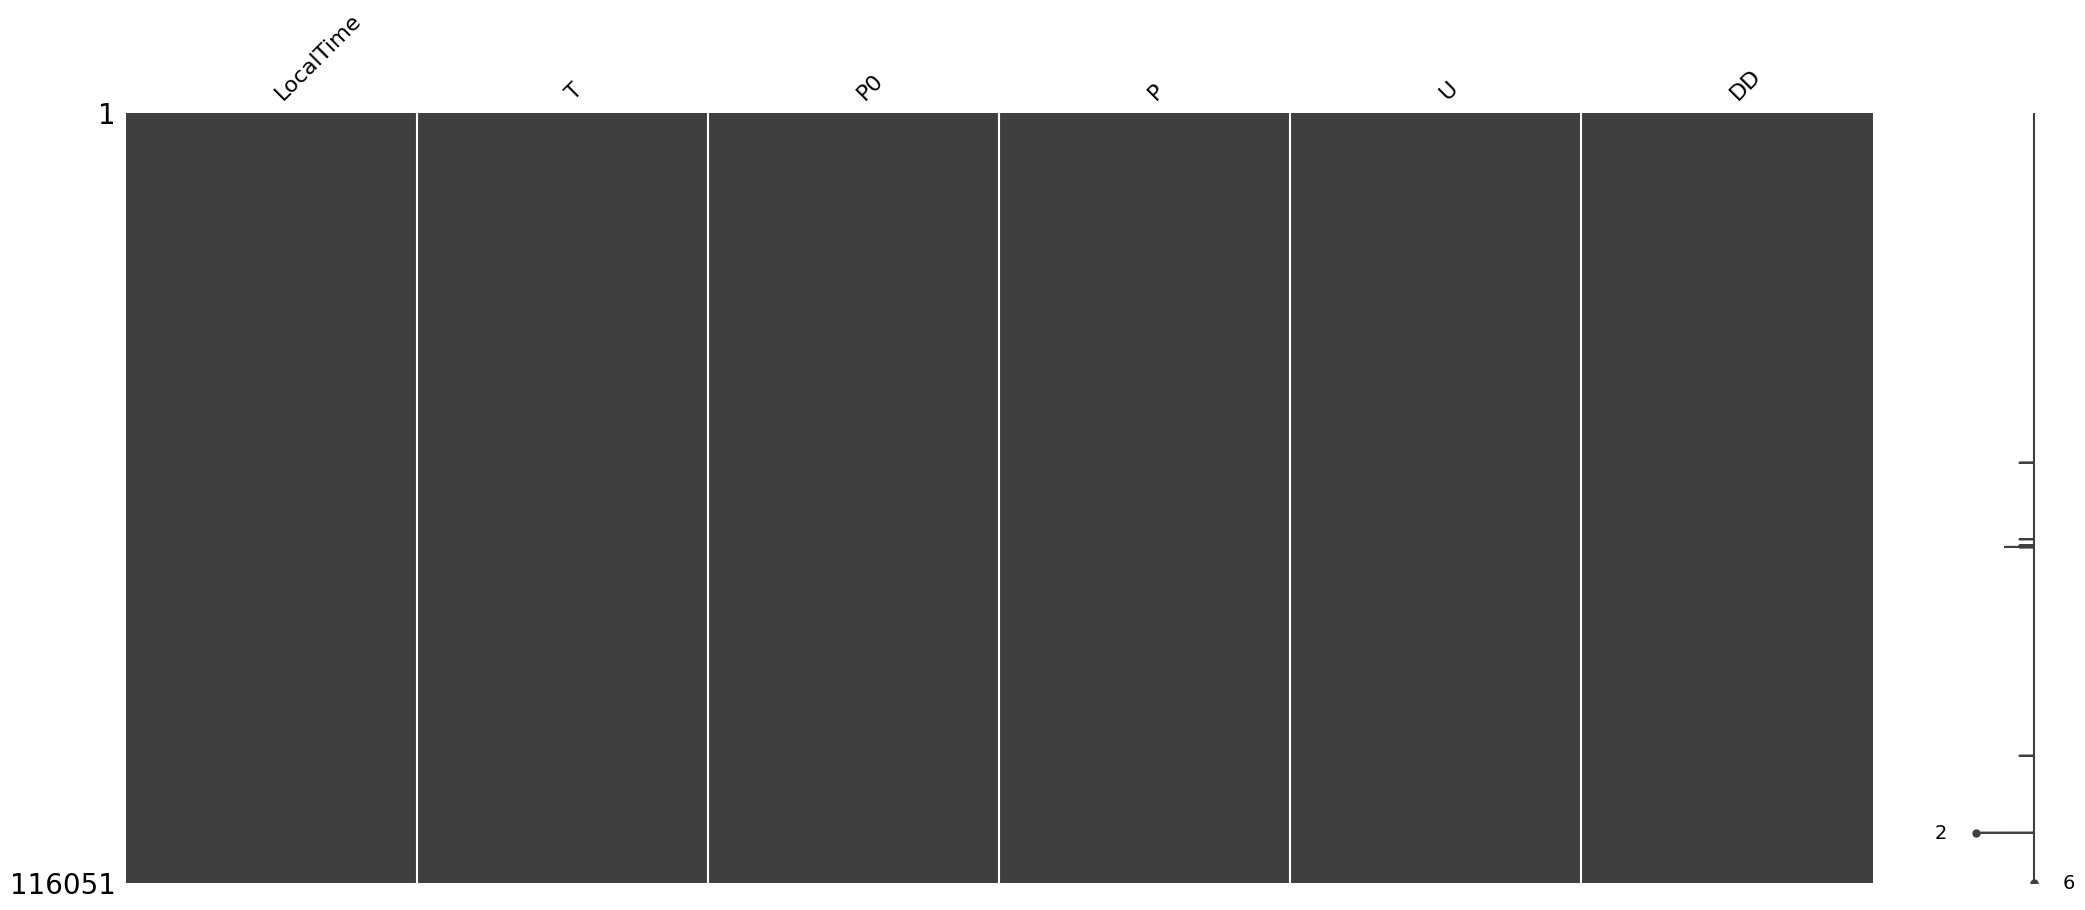

In [20]:
msno.matrix(df)

In [21]:
df.isna().sum()

LocalTime    0
T            1
P0           2
P            2
U            3
DD           3
dtype: int64

Так как пропусков немного, их можно просто удалить.

In [22]:
df = df.dropna()
df.isna().sum()

LocalTime    0
T            0
P0           0
P            0
U            0
DD           0
dtype: int64

####Кодирование категориальных переменных

Выведем информацию о датасете.

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116044 entries, 0 to 116050
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   LocalTime  116044 non-null  object 
 1   T          116044 non-null  float64
 2   P0         116044 non-null  float64
 3   P          116044 non-null  float64
 4   U          116044 non-null  float64
 5   DD         116044 non-null  object 
dtypes: float64(4), object(2)
memory usage: 6.2+ MB


В датасете есть признаки типа object. Закодируем категориальные переменные с помощью LabelEncoder.

In [24]:
df_enc = df.copy()

In [25]:
# Кодирование категориальных факторов

encoder = LabelEncoder()

for i in df_enc:
    if df_enc[i].dtypes == 'object':
       df_enc[i] = encoder.fit_transform(df_enc[i])
df_enc

,LocalTime,T,P0,P,U,DD
0,72172,-7.0,745.9,758.2,68.0,0
1,72171,-6.0,746.0,758.2,63.0,0
2,72170,-5.0,746.0,758.2,58.0,0
3,72169,-4.0,746.1,758.2,59.0,0
4,72168,-4.0,746.1,758.2,54.0,0
...,...,...,...,...,...,...
116046,2805,2.0,742.8,754.6,87.0,0
116047,2804,2.0,743.6,755.4,87.0,0
116048,2803,2.0,743.6,755.4,87.0,0
116049,2802,2.0,744.4,756.2,87.0,0


####Отбор признаков

Построим графики для всех признаков.

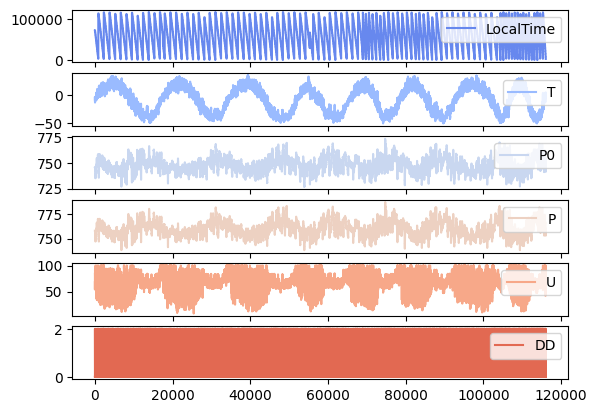

In [26]:
df_enc.plot(subplots=True, legend=False, color = colors)

for ax in plt.gcf().axes:
    ax.legend(loc=1)

Как мы видим, признак DD (направление ветра) не обладает такой периодичностью, как остальные признаки, поэтому его можно исключить из рассмотрения. LocalTime исключается тоже, так как не обладает нужной информативностью.

Создадим датасет рассматриваемых признаков.

In [27]:
# список названий рассматриваемых признаков

features_considered = ['T', 'P0', 'P', 'U']

In [28]:
# количество рассматриваемых признаков

features_num = len(features_considered)

In [29]:
# признаки

features = df_enc[features_considered]

In [30]:
# устанавливаем дату и время в качестве индекса

features.index = df['LocalTime']

In [31]:
features.head()

,T,P0,P,U
LocalTime,,,,
19.10.2020 17:00,-7.0,745.9,758.2,68.0
19.10.2020 16:30,-6.0,746.0,758.2,63.0
19.10.2020 16:00,-5.0,746.0,758.2,58.0
19.10.2020 15:30,-4.0,746.1,758.2,59.0
19.10.2020 15:00,-4.0,746.1,758.2,54.0


####Масштабирование данных

Выполним масштабирование данных в диапазон от 0
до 1.

In [32]:
data = features.copy()

scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)

####Сглаживание данных

Сглаживание данных представляет собой процесс уменьшения шума и выбросов в наборе данных. Чаще всего используется в случаях, когда данные имеют большие колебания или нерегулярности. В нейронных сетях сглаживание данных может помочь снизить эффект переобучения и улучшить общую производительность сети.

Одной из наиболее распространенных техник сглаживания данных является применение метода скользящего среднего. Этот метод заключается в вычислении среднего значения по подмножеству набора данных, а затем замене всех значений этим средним значением. Таким образом, изначально колеблющиеся значения сглаживаются, что позволяет увидеть общую тенденцию данных. Это поможет устранить выбросы и шум в выходных значениях слоя, что повысит точность прогнозирования и обучение сети, так как в результате полученные данные будут более регулярными и лучше соответствовать общей тенденции, что позволит нейронной сети более эффективно обучаться и делать точные прогнозы.

In [33]:
def smooth_data(data, sm_columns, window_size = 20):

  if (sm_columns == []):
    return data

  smoothed_data = np.zeros_like(data)

  for i in range(0, data.shape[0]):

    for j in range(0, data.shape[1]):

      if j in sm_columns:
        start = max(0, i - window_size // 2)
        end = min(len(data), i + window_size // 2 + 1)
        smoothed_data[i,j] = np.mean(data[:, j][start:end])

      else:
        smoothed_data[:,j] = data[:, j]

  return smoothed_data

In [34]:
#sm_cols = ['T', 'P0', 'P', 'U']
sm_cols = []

In [35]:
sm_cols_idx = []

for colname in sm_cols:
  sm_cols_idx.append(sm_cols.index(colname))
  #print(features_considered.index(colname))

In [36]:
# последний столбец - ветер - не сглаживаем
window_size = 20
sm_data = smooth_data(data, sm_cols_idx, window_size)

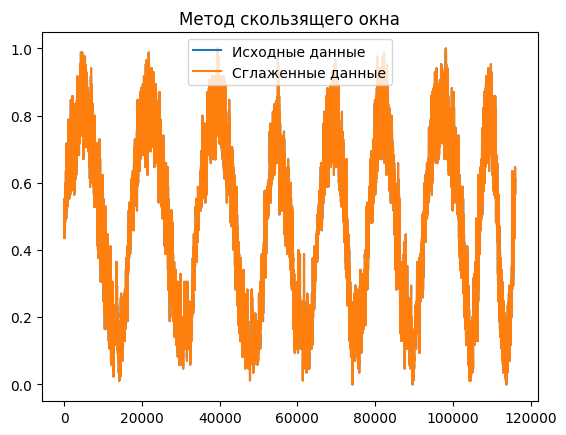

In [37]:
plt.plot(data[:,0], label='Исходные данные')
plt.plot(sm_data[:, 0], label='Сглаженные данные')
plt.title('Метод скользящего окна')
plt.legend()
plt.show()

####Сериализация данных

Приведенная ниже функция возвращает временные интервалы для обучения модели. Аригумент series_size - это количество предыдущих значений, используемых для прогноза.

In [118]:
def create_time_series(data, series_size):
  Y_index = np.arange(series_size, len(data), series_size)
  Y = data[:, 0][Y_index]
  Y = np.reshape(Y, (-1, 1))

  rows_x = len(Y)

  X = np.zeros_like(data[:, :])

  X = data[:, :][range(series_size*rows_x)]
  X = np.reshape(X, (rows_x, series_size, -1))

  return X, Y

In [119]:
series_size = 72

X, y = create_time_series(sm_data, series_size)

####Разделение на выборки

Разбиение выборки на обучающую и тестовую, на обучающей выборке будет обучаться
модель, на тестовой будет проводится оценка.

In [120]:
# выборки для обучения

X_train, X_test, y_train, y_test = train_test_split(
  X,
  y,
  train_size=0.7,
  random_state=0
)

In [121]:
# выборки для тестирования и валидации

X_test, X_val, y_test, y_val = train_test_split(
  X_test,
  y_test,
  train_size=0.5,
  random_state=0
)

###Simple RNN

SimpleRNN в Keras - это реализация простой рекуррентной нейронной сети (RNN) в библиотеке Keras. RNN является одним из типов нейронных сетей, которые поддерживают обработку последовательных данных, таких как временные ряды или естественные языки.

SimpleRNN имеет один скрытый слой, который рекурсивно передает информацию из предыдущего временного шага в следующий. Это связано с возможностью моделирования долгосрочных зависимостей в данных. SimpleRNN может быть использован для задач классификации, регрессии или генерации последовательностей.

####Модель №1

Создаем полносвязную модель рекуррентной нейронной сети с одним скрытым слоем.
Выходной слой возвращает одно число - температуру. В качестве функции потерь
используется средняя абсолютная ошибка (mae), оптимизатор — adam, во время обучения
будем отслеживать метрики mse, среднюю абсолютную ошибку (mae) и коэффициент детерминации R^2.

Слой RNN содержит 32 нейрона, функция активации - relu. Параметр return_sequences означает, следует ли возвращать последний вывод в выходной последовательности или полную последовательность, в данном случае он установлен в False, то есть слой RNN возвращает только последний вывод. Размеры входного вектора (input_shape) - (количество наблюдений в серии, количество признаков).

Слой Dense содержит 1 нейрон, функция активации - линейная.

В качестве функции потерь используем MSE, используемые метрики - MAE, MSE, R2. Оптимизатор - adam.

Модель будет обучена на 20 эпохах с размером батча, равным 32.





In [122]:
# ассоциативный массив параметров архитектуры модели
# и обучения модели

Params = dict()

rnn_params = dict()
dense_params = dict()
compile_params = dict()
train_params = dict()

rnn_params['units'] = 32
rnn_params['input_shape'] = (series_size,features_num)
rnn_params['activation'] = ['relu']
rnn_params['is_sequences'] = [False]

dense_params['units'] = 1
dense_params['activation'] = ['linear']

compile_params['loss'] = 'mean_squared_error'
compile_params['optimizer'] = 'adam'
compile_params['metrics'] = [
              'mean_absolute_error',
              'mean_squared_error',
              RSquare()
            ]

train_params['epochs'] = 20
train_params['batch_size'] = 32



Params['rnn_params'] = rnn_params
Params['dense_params'] = dense_params
Params['compile_params'] = compile_params
Params['train_params'] = train_params

In [123]:
Params

{'rnn_params': {'units': 32,
  'input_shape': (72, 4),
  'activation': ['relu'],
  'is_sequences': [False]},
 'dense_params': {'units': 1, 'activation': ['linear']},
 'compile_params': {'loss': 'mean_squared_error',
  'optimizer': 'adam',
  'metrics': ['mean_absolute_error',
   'mean_squared_error',
   <tensorflow_addons.metrics.r_square.RSquare at 0x79911836a3b0>]},
 'train_params': {'epochs': 20, 'batch_size': 32}}

In [124]:
rnn_model_1 = Sequential()

rnn_model_1.add(
    SimpleRNN(
            Params['rnn_params']['units'],
            input_shape = Params['rnn_params']['input_shape'],
            activation = Params['rnn_params']['activation'][0],
            return_sequences = Params['rnn_params']['is_sequences'][0]
          )
      )

rnn_model_1.add(
    Dense(
        units = Params['dense_params']['units'],
        activation = Params['dense_params']['activation'][0]
      )
    )

rnn_model_1.compile(
    loss = Params['compile_params']['loss'],
    optimizer = Params['compile_params']['optimizer'],
    metrics = Params['compile_params']['metrics']
  )

rnn_model_1.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_4 (SimpleRNN)    (None, 32)                1184      
                                                                 
 dense_10 (Dense)            (None, 1)                 33        
                                                                 
Total params: 1217 (4.75 KB)
Trainable params: 1217 (4.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#####Обучение модели

In [125]:
rnn_model_1_history = rnn_model_1.fit(
    X_train,
    y_train,
    validation_data = (X_val,y_val),
    epochs = Params['train_params']['epochs'],
    batch_size = Params['train_params']['batch_size'],
    verbose = 1
  )

Epoch 1/20
36/36 [==============================] - 4s 35ms/step - loss: 0.0087 - mean_absolute_error: 0.0692 - mean_squared_error: 0.0087 - r_square: 0.8660 - val_loss: 0.0016 - val_mean_absolute_error: 0.0323 - val_mean_squared_error: 0.0016 - val_r_square: 0.9766
Epoch 2/20
36/36 [==============================] - 1s 22ms/step - loss: 0.0011 - mean_absolute_error: 0.0251 - mean_squared_error: 0.0011 - r_square: 0.9835 - val_loss: 9.8672e-04 - val_mean_absolute_error: 0.0234 - val_mean_squared_error: 9.8672e-04 - val_r_square: 0.9859
Epoch 3/20
36/36 [==============================] - 1s 26ms/step - loss: 8.0397e-04 - mean_absolute_error: 0.0213 - mean_squared_error: 8.0397e-04 - r_square: 0.9877 - val_loss: 8.4309e-04 - val_mean_absolute_error: 0.0224 - val_mean_squared_error: 8.4309e-04 - val_r_square: 0.9880
Epoch 4/20
36/36 [==============================] - 0s 13ms/step - loss: 7.1877e-04 - mean_absolute_error: 0.0201 - mean_squared_error: 7.1877e-04 - r_square: 0.9890 - val_los

#####Визуализация процесса обучения

После построим предсказания и визуализируем их. Построим график для визуализации
изменения оценки модели на разных эпохах.

<ipython-input-15-b0a0bfc8f622>:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "y" (-> color=(0.75, 0.75, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, loss, 'y', label='Training loss', color = colors[0])
<ipython-input-15-b0a0bfc8f622>:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_loss, 'r', label='Validation loss', color = colors[len(colors) - 1])


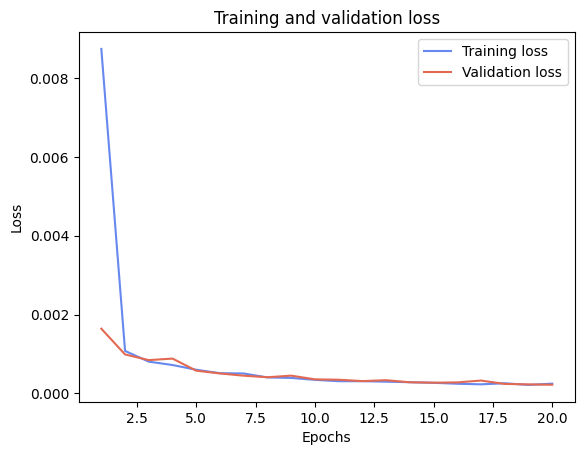

In [126]:
history_visualization(rnn_model_1_history, colors)

Выполним вывод различных метрик оценки качества модели.

In [127]:
print_metrics(rnn_model_1, X_test, y_test)

8/8 [==============================] - 0s 6ms/step
Mean squared error from neural network:  0.00018789632371779148
Mean absolute error from neural network:  0.010064852638844738
R2 score from neural network:  0.9972871961585899


Визуализируем предсказание модели и сравним с реальными данными.

8/8 [==============================] - 0s 5ms/step


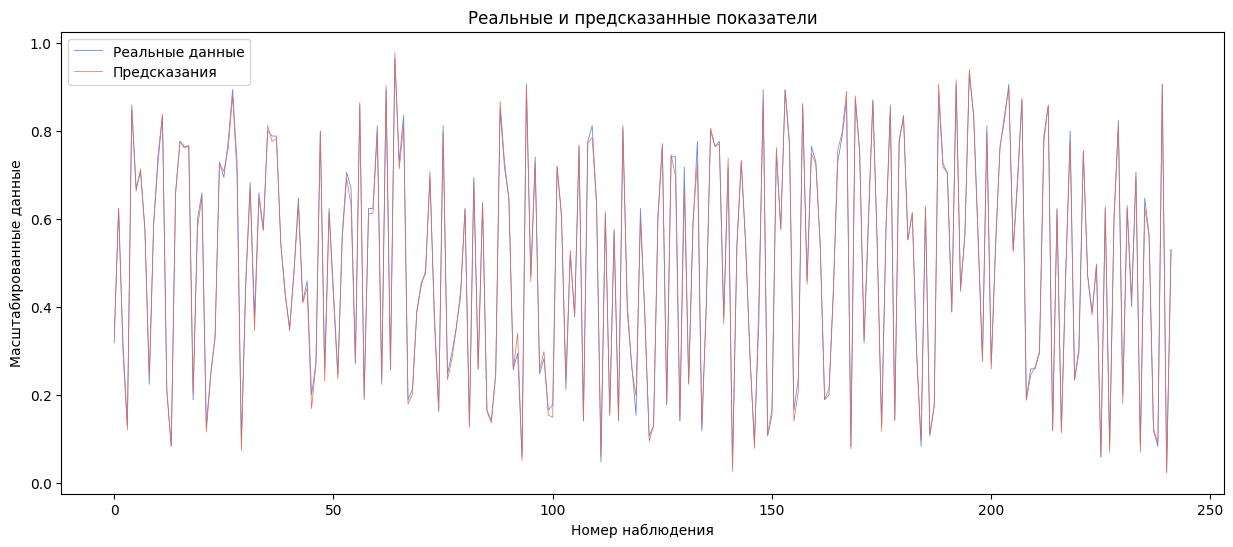

In [128]:
plot_predictions(rnn_model_1, X_test, y_test, colors)

Как видно из последнего графика, предсказанные значения практически совпадают с реальными данными.

####Модель №2

Попробуем изменить оптимизатор на RMSprop и уменьшить размер батча до 8. Увеличим количество эпох до 30. Другие параметры остаются прежними.

In [129]:
Params = dict()

rnn_params = dict()
dense_params = dict()
compile_params = dict()
train_params = dict()

rnn_params['units'] = 32
rnn_params['input_shape'] = (series_size,features_num)
rnn_params['activation'] = ['relu']
rnn_params['is_sequences'] = [False]

dense_params['units'] = 1
dense_params['activation'] = ['linear']

compile_params['loss'] = 'mean_squared_error'
compile_params['optimizer'] = 'RMSprop'
compile_params['metrics'] = [
              'mean_absolute_error',
              'mean_squared_error',
              RSquare()
            ]

train_params['epochs'] = 30
train_params['batch_size'] = 8



Params['rnn_params'] = rnn_params
Params['dense_params'] = dense_params
Params['compile_params'] = compile_params
Params['train_params'] = train_params

In [130]:
Params

{'rnn_params': {'units': 32,
  'input_shape': (72, 4),
  'activation': ['relu'],
  'is_sequences': [False]},
 'dense_params': {'units': 1, 'activation': ['linear']},
 'compile_params': {'loss': 'mean_squared_error',
  'optimizer': 'RMSprop',
  'metrics': ['mean_absolute_error',
   'mean_squared_error',
   <tensorflow_addons.metrics.r_square.RSquare at 0x799124ca8880>]},
 'train_params': {'epochs': 30, 'batch_size': 8}}

In [131]:
rnn_model_2 = Sequential()

rnn_model_2.add(
    SimpleRNN(
            Params['rnn_params']['units'],
            input_shape = Params['rnn_params']['input_shape'],
            activation = Params['rnn_params']['activation'][0],
            return_sequences = Params['rnn_params']['is_sequences'][0]
          )
      )

rnn_model_2.add(
    Dense(
        units = Params['dense_params']['units'],
        activation = Params['dense_params']['activation'][0]
      )
    )

rnn_model_2.compile(
    loss = Params['compile_params']['loss'],
    optimizer = Params['compile_params']['optimizer'],
    metrics = Params['compile_params']['metrics']
  )

rnn_model_2.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_5 (SimpleRNN)    (None, 32)                1184      
                                                                 
 dense_11 (Dense)            (None, 1)                 33        
                                                                 
Total params: 1217 (4.75 KB)
Trainable params: 1217 (4.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#####Обучение модели

In [132]:
rnn_model_2_history = rnn_model_2.fit(
    X_train,
    y_train,
    validation_data = (X_val,y_val),
    epochs = Params['train_params']['epochs'],
    batch_size = Params['train_params']['batch_size'],
    verbose = 1
  )

Epoch 1/30
141/141 [==============================] - 3s 14ms/step - loss: 0.0223 - mean_absolute_error: 0.0951 - mean_squared_error: 0.0223 - r_square: 0.6581 - val_loss: 0.0038 - val_mean_absolute_error: 0.0531 - val_mean_squared_error: 0.0038 - val_r_square: 0.9460
Epoch 2/30
141/141 [==============================] - 2s 12ms/step - loss: 0.0023 - mean_absolute_error: 0.0388 - mean_squared_error: 0.0023 - r_square: 0.9646 - val_loss: 0.0017 - val_mean_absolute_error: 0.0355 - val_mean_squared_error: 0.0017 - val_r_square: 0.9756
Epoch 3/30
141/141 [==============================] - 3s 18ms/step - loss: 0.0015 - mean_absolute_error: 0.0311 - mean_squared_error: 0.0015 - r_square: 0.9770 - val_loss: 5.3966e-04 - val_mean_absolute_error: 0.0180 - val_mean_squared_error: 5.3966e-04 - val_r_square: 0.9923
Epoch 4/30
141/141 [==============================] - 3s 21ms/step - loss: 0.0012 - mean_absolute_error: 0.0274 - mean_squared_error: 0.0012 - r_square: 0.9818 - val_loss: 0.0015 - val_

#####Визуализация процесса обучения

После построим предсказания и визуализируем их. Построим график для визуализации
изменения оценки модели на разных эпохах.

<ipython-input-15-b0a0bfc8f622>:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "y" (-> color=(0.75, 0.75, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, loss, 'y', label='Training loss', color = colors[0])
<ipython-input-15-b0a0bfc8f622>:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_loss, 'r', label='Validation loss', color = colors[len(colors) - 1])


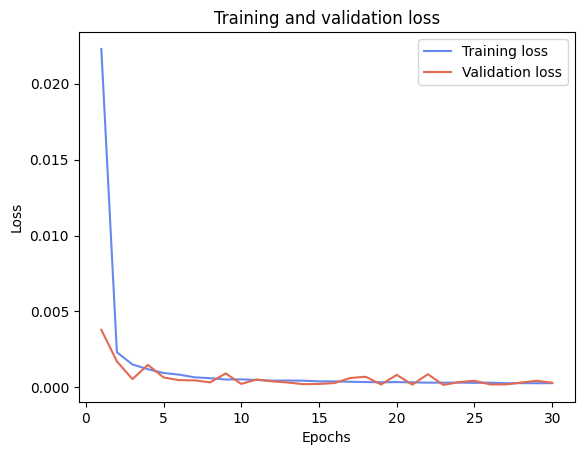

In [133]:
history_visualization(rnn_model_2_history, colors)

Выполним вывод различных метрик оценки качества модели.

In [134]:
print_metrics(rnn_model_2, X_test, y_test)

8/8 [==============================] - 0s 5ms/step
Mean squared error from neural network:  0.00028781927904386134
Mean absolute error from neural network:  0.014049854147482062
R2 score from neural network:  0.995844531546052


Визуализируем предсказание модели и сравним с реальными данными.

8/8 [==============================] - 0s 5ms/step


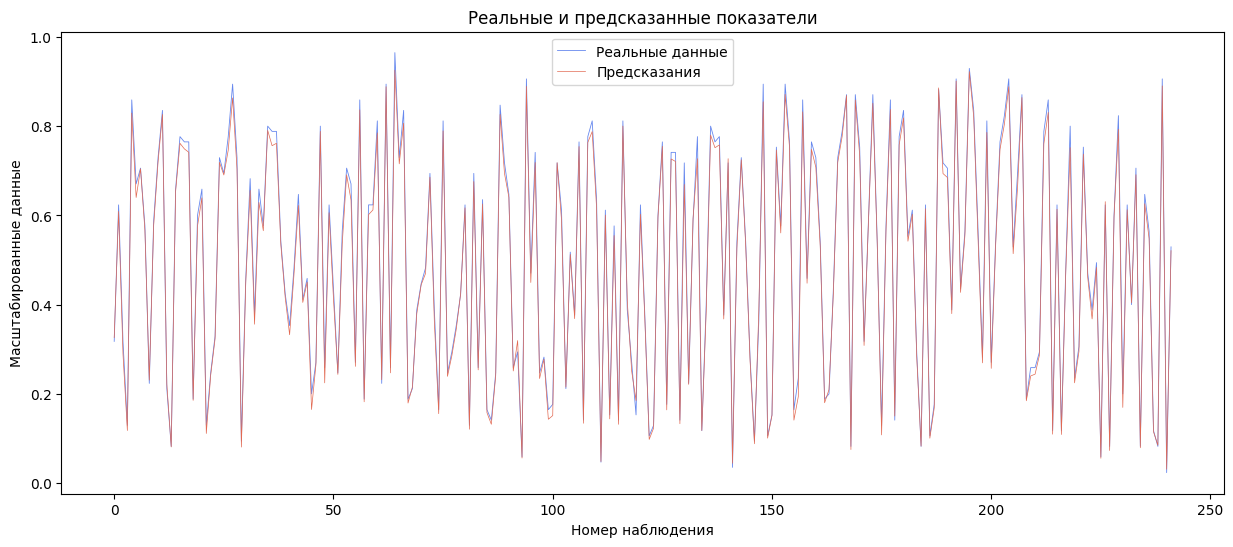

In [135]:
plot_predictions(rnn_model_2, X_test, y_test, colors)

Как видим, обучение модели с оптимизатором RMSprop щло не так гладко, как с adam, но, тем не менее, с выбранными параметрами модель обучилась достаточно хорошо и предсказывает с высокой точностью.

####Модель №3

Оставим в качестве оптимизатора adam, потому что с ним кривая потерь более гладкая. Увеличим количество нейронов в RNN до 64, вернем прежний размер батча - 32 и будем обучать модель в течение 30 эпох.

In [136]:
Params = dict()

rnn_params = dict()
dense_params = dict()
compile_params = dict()
train_params = dict()

rnn_params['units'] = 64
rnn_params['input_shape'] = (series_size,features_num)
rnn_params['activation'] = ['relu']
rnn_params['is_sequences'] = [False]

dense_params['units'] = 1
dense_params['activation'] = ['linear']

compile_params['loss'] = 'mean_squared_error'
compile_params['optimizer'] = 'adam'
compile_params['metrics'] = [
              'mean_absolute_error',
              'mean_squared_error',
              RSquare()
            ]

train_params['epochs'] = 30
train_params['batch_size'] = 32



Params['rnn_params'] = rnn_params
Params['dense_params'] = dense_params
Params['compile_params'] = compile_params
Params['train_params'] = train_params

In [137]:
Params

{'rnn_params': {'units': 64,
  'input_shape': (72, 4),
  'activation': ['relu'],
  'is_sequences': [False]},
 'dense_params': {'units': 1, 'activation': ['linear']},
 'compile_params': {'loss': 'mean_squared_error',
  'optimizer': 'adam',
  'metrics': ['mean_absolute_error',
   'mean_squared_error',
   <tensorflow_addons.metrics.r_square.RSquare at 0x799110776350>]},
 'train_params': {'epochs': 30, 'batch_size': 32}}

In [138]:
rnn_model_3 = Sequential()

rnn_model_3.add(
    SimpleRNN(
            Params['rnn_params']['units'],
            input_shape = Params['rnn_params']['input_shape'],
            activation = Params['rnn_params']['activation'][0],
            return_sequences = Params['rnn_params']['is_sequences'][0]
          )
      )

rnn_model_3.add(
    Dense(
        units = Params['dense_params']['units'],
        activation = Params['dense_params']['activation'][0]
      )
    )

rnn_model_3.compile(
    loss = Params['compile_params']['loss'],
    optimizer = Params['compile_params']['optimizer'],
    metrics = Params['compile_params']['metrics']
  )

rnn_model_3.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_6 (SimpleRNN)    (None, 64)                4416      
                                                                 
 dense_12 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4481 (17.50 KB)
Trainable params: 4481 (17.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#####Обучение модели

In [139]:
rnn_model_3_history = rnn_model_3.fit(
    X_train,
    y_train,
    validation_data = (X_val,y_val),
    epochs = Params['train_params']['epochs'],
    batch_size = Params['train_params']['batch_size'],
    verbose = 1
  )

Epoch 1/30
36/36 [==============================] - 2s 23ms/step - loss: 0.0683 - mean_absolute_error: 0.1709 - mean_squared_error: 0.0683 - r_square: -0.0470 - val_loss: 0.0023 - val_mean_absolute_error: 0.0384 - val_mean_squared_error: 0.0023 - val_r_square: 0.9675
Epoch 2/30
36/36 [==============================] - 1s 15ms/step - loss: 0.0013 - mean_absolute_error: 0.0293 - mean_squared_error: 0.0013 - r_square: 0.9794 - val_loss: 0.0011 - val_mean_absolute_error: 0.0271 - val_mean_squared_error: 0.0011 - val_r_square: 0.9848
Epoch 3/30
36/36 [==============================] - 1s 14ms/step - loss: 6.0849e-04 - mean_absolute_error: 0.0192 - mean_squared_error: 6.0849e-04 - r_square: 0.9907 - val_loss: 5.9331e-04 - val_mean_absolute_error: 0.0194 - val_mean_squared_error: 5.9331e-04 - val_r_square: 0.9915
Epoch 4/30
36/36 [==============================] - 1s 15ms/step - loss: 4.2905e-04 - mean_absolute_error: 0.0161 - mean_squared_error: 4.2905e-04 - r_square: 0.9934 - val_loss: 4.92

#####Визуализация процесса обучения

После построим предсказания и визуализируем их. Построим график для визуализации
изменения оценки модели на разных эпохах.

<ipython-input-15-b0a0bfc8f622>:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "y" (-> color=(0.75, 0.75, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, loss, 'y', label='Training loss', color = colors[0])
<ipython-input-15-b0a0bfc8f622>:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_loss, 'r', label='Validation loss', color = colors[len(colors) - 1])


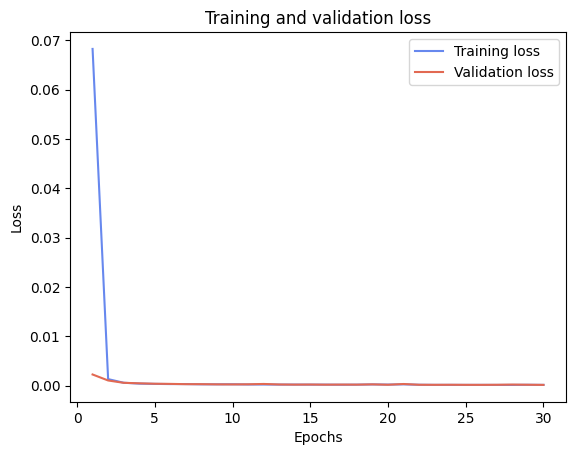

In [140]:
history_visualization(rnn_model_3_history, colors)

Выполним вывод различных метрик оценки качества модели.

In [141]:
print_metrics(rnn_model_3, X_test, y_test)

8/8 [==============================] - 0s 10ms/step
Mean squared error from neural network:  0.0001850091553628759
Mean absolute error from neural network:  0.00985130107643307
R2 score from neural network:  0.9973288804302618


Визуализируем предсказание модели и сравним с реальными данными.

8/8 [==============================] - 0s 9ms/step


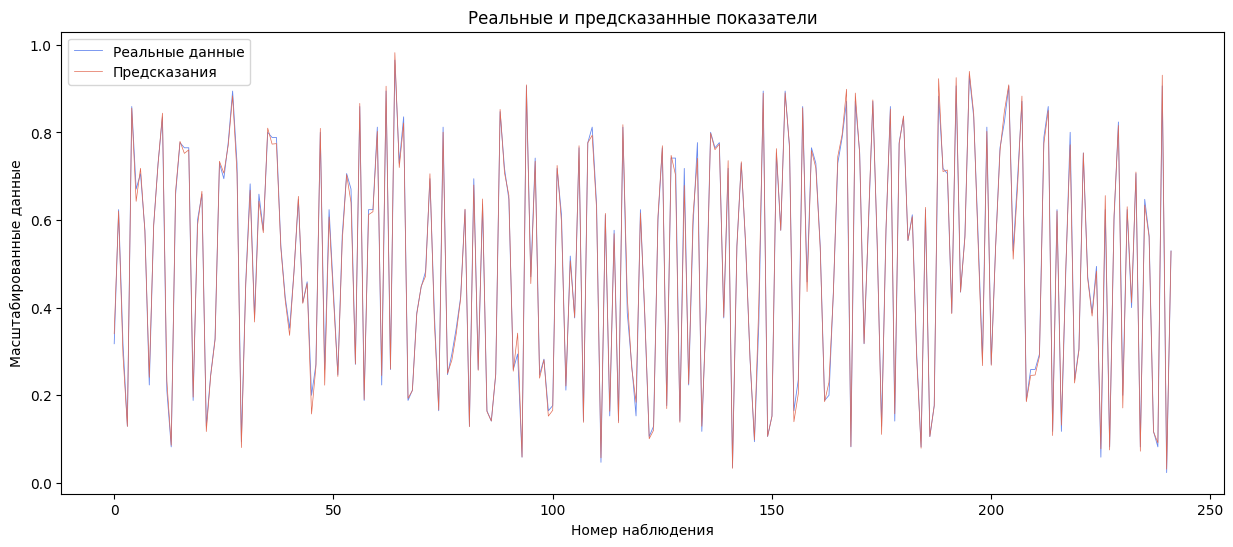

In [142]:
plot_predictions(rnn_model_3, X_test, y_test, colors)

Увеличение количества нейронов не привело к обучению. Процесс обучения модели шел гладко и, как видно по графикам, предсказанные значения практически совпадают с реальными.

####Модель №4

Проведем эксперименты со слоем Dropout. Добавим в RNN-слой параметр dropout, равный 0.1. Количество эпох установив равным 30 и добавим callback для ранней остановки, который остановит обучение, если в течение 5 эпох mae на валидационной выборке не уменьшится.

In [143]:
Params = dict()

rnn_params = dict()
dense_params = dict()
compile_params = dict()
train_params = dict()

rnn_params['units'] = 64
rnn_params['input_shape'] = (series_size,features_num)
rnn_params['activation'] = ['relu']
rnn_params['is_sequences'] = [False]
rnn_params['dropout'] = [0.1]


dense_params['units'] = 1
dense_params['activation'] = ['linear']

compile_params['loss'] = 'mean_squared_error'
compile_params['optimizer'] = 'adam'
compile_params['metrics'] = [
              'mean_absolute_error',
              'mean_squared_error',
              RSquare()
            ]

train_params['epochs'] = 30
train_params['batch_size'] = 32



Params['rnn_params'] = rnn_params
Params['dense_params'] = dense_params
Params['compile_params'] = compile_params
Params['train_params'] = train_params

In [144]:
Params

{'rnn_params': {'units': 64,
  'input_shape': (72, 4),
  'activation': ['relu'],
  'is_sequences': [False],
  'dropout': [0.1]},
 'dense_params': {'units': 1, 'activation': ['linear']},
 'compile_params': {'loss': 'mean_squared_error',
  'optimizer': 'adam',
  'metrics': ['mean_absolute_error',
   'mean_squared_error',
   <tensorflow_addons.metrics.r_square.RSquare at 0x7991103558a0>]},
 'train_params': {'epochs': 30, 'batch_size': 32}}

In [145]:
rnn_model_4 = Sequential()

rnn_model_4.add(
    SimpleRNN(
            Params['rnn_params']['units'],
            input_shape = Params['rnn_params']['input_shape'],
            activation = Params['rnn_params']['activation'][0],
            dropout = Params['rnn_params']['dropout'][0],
            return_sequences = Params['rnn_params']['is_sequences'][0]
          )
      )

rnn_model_4.add(
    Dense(
        units = Params['dense_params']['units'],
        activation = Params['dense_params']['activation'][0]
      )
    )

rnn_model_4.compile(
    loss = Params['compile_params']['loss'],
    optimizer = Params['compile_params']['optimizer'],
    metrics = Params['compile_params']['metrics']
  )

rnn_model_4.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_7 (SimpleRNN)    (None, 64)                4416      
                                                                 
 dense_13 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4481 (17.50 KB)
Trainable params: 4481 (17.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#####Обучение модели

In [146]:
early_stop = EarlyStopping(
    monitor = 'val_mae',
    patience = 5,
    mode = 'min',
    verbose = 1
  )

callbacks_list = [early_stop]

In [147]:
rnn_model_4_history = rnn_model_4.fit(
    X_train,
    y_train,
    validation_data = (X_val,y_val),
    epochs = Params['train_params']['epochs'],
    batch_size = Params['train_params']['batch_size'],
    callbacks = callbacks_list,
    verbose = 1
  )

Epoch 1/30
36/36 [==============================] - ETA: 0s - loss: 0.0251 - mean_absolute_error: 0.1158 - mean_squared_error: 0.0251 - r_square: 0.6144

36/36 [==============================] - 3s 42ms/step - loss: 0.0251 - mean_absolute_error: 0.1158 - mean_squared_error: 0.0251 - r_square: 0.6144 - val_loss: 0.0023 - val_mean_absolute_error: 0.0394 - val_mean_squared_error: 0.0023 - val_r_square: 0.9674
Epoch 2/30
35/36 [============================>.] - ETA: 0s - loss: 0.0062 - mean_absolute_error: 0.0580 - mean_squared_error: 0.0062 - r_square: 0.9046

36/36 [==============================] - 1s 26ms/step - loss: 0.0062 - mean_absolute_error: 0.0579 - mean_squared_error: 0.0062 - r_square: 0.9053 - val_loss: 0.0012 - val_mean_absolute_error: 0.0284 - val_mean_squared_error: 0.0012 - val_r_square: 0.9822
Epoch 3/30
35/36 [============================>.] - ETA: 0s - loss: 0.0031 - mean_absolute_error: 0.0416 - mean_squared_error: 0.0031 - r_square: 0.9527

36/36 [==============================] - 1s 27ms/step - loss: 0.0031 - mean_absolute_error: 0.0416 - mean_squared_error: 0.0031 - r_square: 0.9528 - val_loss: 0.0026 - val_mean_absolute_error: 0.0428 - val_mean_squared_error: 0.0026 - val_r_square: 0.9625
Epoch 4/30
33/36 [==========================>...] - ETA: 0s - loss: 0.0027 - mean_absolute_error: 0.0390 - mean_squared_error: 0.0027 - r_square: 0.9586

36/36 [==============================] - 1s 16ms/step - loss: 0.0026 - mean_absolute_error: 0.0386 - mean_squared_error: 0.0026 - r_square: 0.9597 - val_loss: 0.0056 - val_mean_absolute_error: 0.0629 - val_mean_squared_error: 0.0056 - val_r_square: 0.9199
Epoch 5/30
35/36 [============================>.] - ETA: 0s - loss: 0.0027 - mean_absolute_error: 0.0390 - mean_squared_error: 0.0027 - r_square: 0.9594

36/36 [==============================] - 1s 15ms/step - loss: 0.0026 - mean_absolute_error: 0.0390 - mean_squared_error: 0.0026 - r_square: 0.9594 - val_loss: 0.0017 - val_mean_absolute_error: 0.0337 - val_mean_squared_error: 0.0017 - val_r_square: 0.9765
Epoch 6/30
34/36 [===========================>..] - ETA: 0s - loss: 0.0019 - mean_absolute_error: 0.0338 - mean_squared_error: 0.0019 - r_square: 0.9704

36/36 [==============================] - 1s 16ms/step - loss: 0.0019 - mean_absolute_error: 0.0338 - mean_squared_error: 0.0019 - r_square: 0.9709 - val_loss: 0.0031 - val_mean_absolute_error: 0.0463 - val_mean_squared_error: 0.0031 - val_r_square: 0.9553
Epoch 7/30
33/36 [==========================>...] - ETA: 0s - loss: 0.0016 - mean_absolute_error: 0.0296 - mean_squared_error: 0.0016 - r_square: 0.9760

36/36 [==============================] - 1s 16ms/step - loss: 0.0016 - mean_absolute_error: 0.0296 - mean_squared_error: 0.0016 - r_square: 0.9761 - val_loss: 0.0055 - val_mean_absolute_error: 0.0614 - val_mean_squared_error: 0.0055 - val_r_square: 0.9218
Epoch 8/30
33/36 [==========================>...] - ETA: 0s - loss: 0.0019 - mean_absolute_error: 0.0332 - mean_squared_error: 0.0019 - r_square: 0.9707

36/36 [==============================] - 1s 16ms/step - loss: 0.0019 - mean_absolute_error: 0.0328 - mean_squared_error: 0.0019 - r_square: 0.9710 - val_loss: 0.0043 - val_mean_absolute_error: 0.0539 - val_mean_squared_error: 0.0043 - val_r_square: 0.9390
Epoch 9/30
34/36 [===========================>..] - ETA: 0s - loss: 0.0011 - mean_absolute_error: 0.0253 - mean_squared_error: 0.0011 - r_square: 0.9832

36/36 [==============================] - 1s 15ms/step - loss: 0.0011 - mean_absolute_error: 0.0254 - mean_squared_error: 0.0011 - r_square: 0.9830 - val_loss: 0.0014 - val_mean_absolute_error: 0.0309 - val_mean_squared_error: 0.0014 - val_r_square: 0.9796
Epoch 10/30
36/36 [==============================] - ETA: 0s - loss: 0.0018 - mean_absolute_error: 0.0325 - mean_squared_error: 0.0018 - r_square: 0.9726

36/36 [==============================] - 1s 16ms/step - loss: 0.0018 - mean_absolute_error: 0.0325 - mean_squared_error: 0.0018 - r_square: 0.9726 - val_loss: 0.0028 - val_mean_absolute_error: 0.0432 - val_mean_squared_error: 0.0028 - val_r_square: 0.9603
Epoch 11/30
34/36 [===========================>..] - ETA: 0s - loss: 0.0013 - mean_absolute_error: 0.0273 - mean_squared_error: 0.0013 - r_square: 0.9807

36/36 [==============================] - 1s 15ms/step - loss: 0.0012 - mean_absolute_error: 0.0272 - mean_squared_error: 0.0012 - r_square: 0.9808 - val_loss: 0.0034 - val_mean_absolute_error: 0.0473 - val_mean_squared_error: 0.0034 - val_r_square: 0.9515
Epoch 12/30
33/36 [==========================>...] - ETA: 0s - loss: 0.0010 - mean_absolute_error: 0.0240 - mean_squared_error: 0.0010 - r_square: 0.9844

36/36 [==============================] - 1s 15ms/step - loss: 0.0010 - mean_absolute_error: 0.0239 - mean_squared_error: 0.0010 - r_square: 0.9845 - val_loss: 0.0045 - val_mean_absolute_error: 0.0546 - val_mean_squared_error: 0.0045 - val_r_square: 0.9360
Epoch 13/30
33/36 [==========================>...] - ETA: 0s - loss: 9.2139e-04 - mean_absolute_error: 0.0230 - mean_squared_error: 9.2139e-04 - r_square: 0.9859

36/36 [==============================] - 1s 16ms/step - loss: 9.1688e-04 - mean_absolute_error: 0.0229 - mean_squared_error: 9.1688e-04 - r_square: 0.9859 - val_loss: 0.0032 - val_mean_absolute_error: 0.0470 - val_mean_squared_error: 0.0032 - val_r_square: 0.9542
Epoch 14/30
36/36 [==============================] - ETA: 0s - loss: 8.7114e-04 - mean_absolute_error: 0.0223 - mean_squared_error: 8.7114e-04 - r_square: 0.9866

36/36 [==============================] - 1s 18ms/step - loss: 8.7114e-04 - mean_absolute_error: 0.0223 - mean_squared_error: 8.7114e-04 - r_square: 0.9866 - val_loss: 0.0035 - val_mean_absolute_error: 0.0488 - val_mean_squared_error: 0.0035 - val_r_square: 0.9499
Epoch 15/30
35/36 [============================>.] - ETA: 0s - loss: 9.7138e-04 - mean_absolute_error: 0.0229 - mean_squared_error: 9.7138e-04 - r_square: 0.9851

36/36 [==============================] - 1s 18ms/step - loss: 9.7090e-04 - mean_absolute_error: 0.0229 - mean_squared_error: 9.7090e-04 - r_square: 0.9851 - val_loss: 0.0040 - val_mean_absolute_error: 0.0557 - val_mean_squared_error: 0.0040 - val_r_square: 0.9433
Epoch 16/30
33/36 [==========================>...] - ETA: 0s - loss: 9.1870e-04 - mean_absolute_error: 0.0232 - mean_squared_error: 9.1870e-04 - r_square: 0.9859

36/36 [==============================] - 1s 16ms/step - loss: 9.5002e-04 - mean_absolute_error: 0.0236 - mean_squared_error: 9.5002e-04 - r_square: 0.9854 - val_loss: 0.0026 - val_mean_absolute_error: 0.0419 - val_mean_squared_error: 0.0026 - val_r_square: 0.9636
Epoch 17/30
36/36 [==============================] - ETA: 0s - loss: 0.0010 - mean_absolute_error: 0.0247 - mean_squared_error: 0.0010 - r_square: 0.9842

36/36 [==============================] - 1s 16ms/step - loss: 0.0010 - mean_absolute_error: 0.0247 - mean_squared_error: 0.0010 - r_square: 0.9842 - val_loss: 0.0035 - val_mean_absolute_error: 0.0525 - val_mean_squared_error: 0.0035 - val_r_square: 0.9496
Epoch 18/30
34/36 [===========================>..] - ETA: 0s - loss: 7.5588e-04 - mean_absolute_error: 0.0210 - mean_squared_error: 7.5588e-04 - r_square: 0.9884

36/36 [==============================] - 1s 16ms/step - loss: 7.7093e-04 - mean_absolute_error: 0.0213 - mean_squared_error: 7.7093e-04 - r_square: 0.9882 - val_loss: 0.0025 - val_mean_absolute_error: 0.0419 - val_mean_squared_error: 0.0025 - val_r_square: 0.9637
Epoch 19/30
33/36 [==========================>...] - ETA: 0s - loss: 0.0010 - mean_absolute_error: 0.0248 - mean_squared_error: 0.0010 - r_square: 0.9840        

36/36 [==============================] - 1s 16ms/step - loss: 0.0011 - mean_absolute_error: 0.0253 - mean_squared_error: 0.0011 - r_square: 0.9837 - val_loss: 0.0043 - val_mean_absolute_error: 0.0559 - val_mean_squared_error: 0.0043 - val_r_square: 0.9393
Epoch 20/30
33/36 [==========================>...] - ETA: 0s - loss: 0.0011 - mean_absolute_error: 0.0254 - mean_squared_error: 0.0011 - r_square: 0.9828

36/36 [==============================] - 1s 17ms/step - loss: 0.0011 - mean_absolute_error: 0.0250 - mean_squared_error: 0.0011 - r_square: 0.9832 - val_loss: 0.0040 - val_mean_absolute_error: 0.0534 - val_mean_squared_error: 0.0040 - val_r_square: 0.9424
Epoch 21/30
35/36 [============================>.] - ETA: 0s - loss: 7.7539e-04 - mean_absolute_error: 0.0214 - mean_squared_error: 7.7539e-04 - r_square: 0.9881

36/36 [==============================] - 1s 29ms/step - loss: 7.7501e-04 - mean_absolute_error: 0.0214 - mean_squared_error: 7.7501e-04 - r_square: 0.9881 - val_loss: 0.0040 - val_mean_absolute_error: 0.0546 - val_mean_squared_error: 0.0040 - val_r_square: 0.9430
Epoch 22/30
36/36 [==============================] - ETA: 0s - loss: 8.2352e-04 - mean_absolute_error: 0.0213 - mean_squared_error: 8.2352e-04 - r_square: 0.9874

36/36 [==============================] - 1s 27ms/step - loss: 8.2352e-04 - mean_absolute_error: 0.0213 - mean_squared_error: 8.2352e-04 - r_square: 0.9874 - val_loss: 0.0033 - val_mean_absolute_error: 0.0488 - val_mean_squared_error: 0.0033 - val_r_square: 0.9530
Epoch 23/30
36/36 [==============================] - ETA: 0s - loss: 7.3113e-04 - mean_absolute_error: 0.0206 - mean_squared_error: 7.3113e-04 - r_square: 0.9888

36/36 [==============================] - 1s 27ms/step - loss: 7.3113e-04 - mean_absolute_error: 0.0206 - mean_squared_error: 7.3113e-04 - r_square: 0.9888 - val_loss: 0.0036 - val_mean_absolute_error: 0.0509 - val_mean_squared_error: 0.0036 - val_r_square: 0.9487
Epoch 24/30
36/36 [==============================] - ETA: 0s - loss: 7.6794e-04 - mean_absolute_error: 0.0210 - mean_squared_error: 7.6794e-04 - r_square: 0.9882

36/36 [==============================] - 1s 30ms/step - loss: 7.6794e-04 - mean_absolute_error: 0.0210 - mean_squared_error: 7.6794e-04 - r_square: 0.9882 - val_loss: 0.0029 - val_mean_absolute_error: 0.0462 - val_mean_squared_error: 0.0029 - val_r_square: 0.9586
Epoch 25/30
35/36 [============================>.] - ETA: 0s - loss: 8.3477e-04 - mean_absolute_error: 0.0222 - mean_squared_error: 8.3477e-04 - r_square: 0.9872

36/36 [==============================] - 1s 29ms/step - loss: 8.3064e-04 - mean_absolute_error: 0.0222 - mean_squared_error: 8.3064e-04 - r_square: 0.9873 - val_loss: 0.0029 - val_mean_absolute_error: 0.0459 - val_mean_squared_error: 0.0029 - val_r_square: 0.9588
Epoch 26/30
36/36 [==============================] - ETA: 0s - loss: 5.5184e-04 - mean_absolute_error: 0.0175 - mean_squared_error: 5.5184e-04 - r_square: 0.9915

36/36 [==============================] - 1s 25ms/step - loss: 5.5184e-04 - mean_absolute_error: 0.0175 - mean_squared_error: 5.5184e-04 - r_square: 0.9915 - val_loss: 0.0025 - val_mean_absolute_error: 0.0411 - val_mean_squared_error: 0.0025 - val_r_square: 0.9650
Epoch 27/30
35/36 [============================>.] - ETA: 0s - loss: 6.5339e-04 - mean_absolute_error: 0.0188 - mean_squared_error: 6.5339e-04 - r_square: 0.9900

36/36 [==============================] - 1s 26ms/step - loss: 6.5058e-04 - mean_absolute_error: 0.0187 - mean_squared_error: 6.5058e-04 - r_square: 0.9900 - val_loss: 0.0027 - val_mean_absolute_error: 0.0437 - val_mean_squared_error: 0.0027 - val_r_square: 0.9615
Epoch 28/30
35/36 [============================>.] - ETA: 0s - loss: 5.4997e-04 - mean_absolute_error: 0.0177 - mean_squared_error: 5.4997e-04 - r_square: 0.9916

36/36 [==============================] - 1s 18ms/step - loss: 5.4715e-04 - mean_absolute_error: 0.0177 - mean_squared_error: 5.4715e-04 - r_square: 0.9916 - val_loss: 0.0036 - val_mean_absolute_error: 0.0509 - val_mean_squared_error: 0.0036 - val_r_square: 0.9488
Epoch 29/30
36/36 [==============================] - ETA: 0s - loss: 5.4604e-04 - mean_absolute_error: 0.0177 - mean_squared_error: 5.4604e-04 - r_square: 0.9916

36/36 [==============================] - 1s 17ms/step - loss: 5.4604e-04 - mean_absolute_error: 0.0177 - mean_squared_error: 5.4604e-04 - r_square: 0.9916 - val_loss: 0.0030 - val_mean_absolute_error: 0.0473 - val_mean_squared_error: 0.0030 - val_r_square: 0.9568
Epoch 30/30
33/36 [==========================>...] - ETA: 0s - loss: 6.0804e-04 - mean_absolute_error: 0.0187 - mean_squared_error: 6.0804e-04 - r_square: 0.9907

36/36 [==============================] - 1s 16ms/step - loss: 6.1739e-04 - mean_absolute_error: 0.0187 - mean_squared_error: 6.1739e-04 - r_square: 0.9905 - val_loss: 0.0041 - val_mean_absolute_error: 0.0549 - val_mean_squared_error: 0.0041 - val_r_square: 0.9421


#####Визуализация процесса обучения

После построим предсказания и визуализируем их. Построим график для визуализации
изменения оценки модели на разных эпохах.

<ipython-input-15-b0a0bfc8f622>:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "y" (-> color=(0.75, 0.75, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, loss, 'y', label='Training loss', color = colors[0])
<ipython-input-15-b0a0bfc8f622>:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_loss, 'r', label='Validation loss', color = colors[len(colors) - 1])


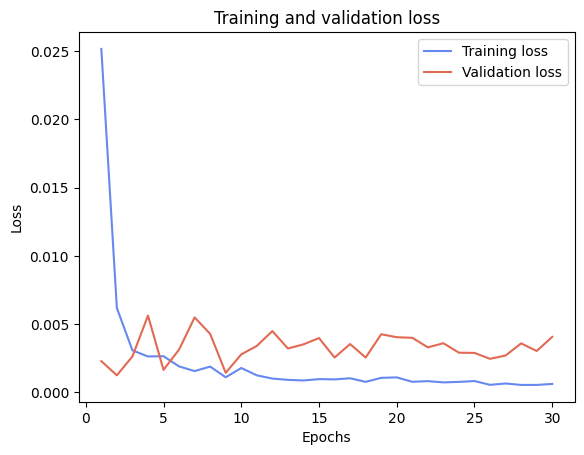

In [148]:
history_visualization(rnn_model_4_history, colors)

Выполним вывод различных метрик оценки качества модели.

In [149]:
print_metrics(rnn_model_4, X_test, y_test)

8/8 [==============================] - 0s 6ms/step
Mean squared error from neural network:  0.003948537983026994
Mean absolute error from neural network:  0.05516781978939395
R2 score from neural network:  0.9429919181154514


Визуализируем предсказание модели и сравним с реальными данными.

8/8 [==============================] - 0s 6ms/step


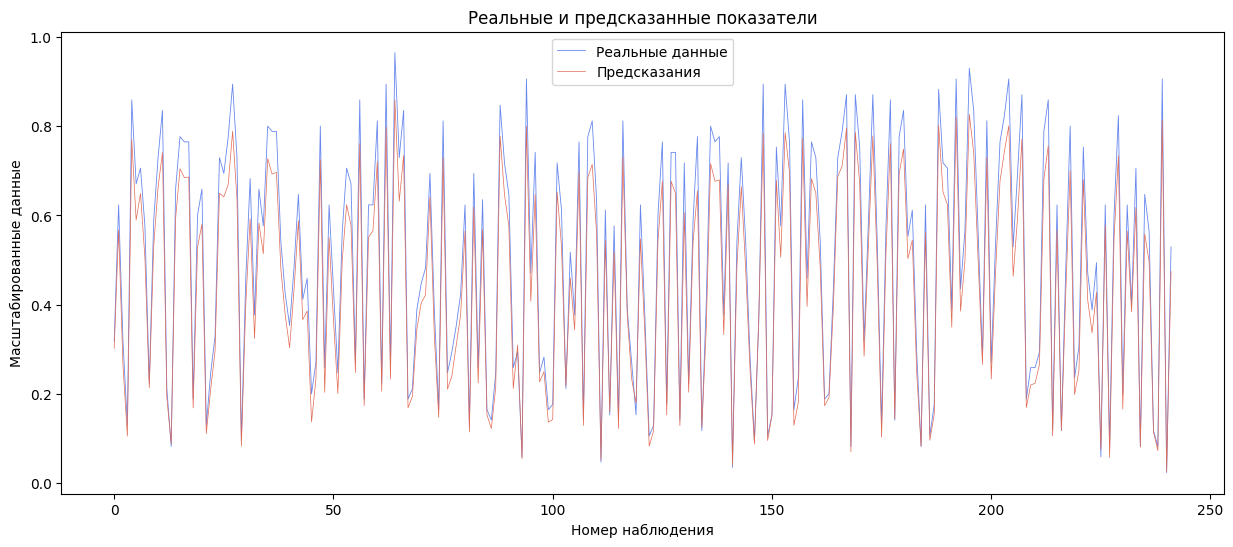

In [150]:
plot_predictions(rnn_model_4, X_test, y_test, colors)

Добавление параметра dropout в данном случае сказалось негативно на качестве модели.

###LSTM

LSTM (Long Short-Term Memory) в Keras представляет собой тип рекуррентной нейронной сети, который используется для обработки последовательностей данных. LSTM способна запоминать и учитывать долгосрочные зависимости в последовательностях данных, что делает ее особенно полезной для работы с текстами, речью, временными рядами и другими типами последовательных данных.

LSTM является одним из типов рекуррентных нейронных сетей и представляет собой улучшенную версию стандартных простых рекуррентных нейронных сетей (RNN). LSTM включает в себя дополнительные блоки памяти, которые помогают сохранять и использовать информацию на протяжении более длительного времени.

####Модель №1

Создаем полносвязную модель рекуррентной нейронной сети с одним скрытым слоем.
Выходной слой возвращает одно число - температуру.

Слой LSTM содержит 32 нейрона, функция активации - relu. Параметр return_sequences означает, следует ли возвращать последний вывод в выходной последовательности или полную последовательность, в данном случае он установлен в False, то есть слой LSTM возвращает только последний вывод. Размеры входного вектора (input_shape) - (количество наблюдений в серии, количество признаков).

Слой Dense содержит 1 нейрон, функция активации - линейная.

В качестве функции потерь используем MSE, используемые метрики - MAE, MSE, R2. Оптимизатор - adam.

Модель будет обучена на 20 эпохах с размером батча равным 32.





In [151]:
Params = dict()

lstm_params = dict()
dense_params = dict()
compile_params = dict()
train_params = dict()

lstm_params['units'] = 32
lstm_params['input_shape'] = (series_size,features_num)
lstm_params['activation'] = ['relu']
lstm_params['is_sequences'] = [False]

dense_params['units'] = 1
dense_params['activation'] = ['linear']

compile_params['loss'] = 'mean_squared_error'
compile_params['optimizer'] = 'adam'
compile_params['metrics'] = [
              'mean_absolute_error',
              'mean_squared_error',
              RSquare()
            ]

train_params['epochs'] = 20
train_params['batch_size'] = 32



Params['lstm_params'] = lstm_params
Params['dense_params'] = dense_params
Params['compile_params'] = compile_params
Params['train_params'] = train_params

In [152]:
Params

{'lstm_params': {'units': 32,
  'input_shape': (72, 4),
  'activation': ['relu'],
  'is_sequences': [False]},
 'dense_params': {'units': 1, 'activation': ['linear']},
 'compile_params': {'loss': 'mean_squared_error',
  'optimizer': 'adam',
  'metrics': ['mean_absolute_error',
   'mean_squared_error',
   <tensorflow_addons.metrics.r_square.RSquare at 0x7990fd609540>]},
 'train_params': {'epochs': 20, 'batch_size': 32}}

In [153]:
lstm_model_1 = Sequential()

lstm_model_1.add(
    LSTM(
          Params['lstm_params']['units'],
          input_shape = Params['lstm_params']['input_shape'],
          activation = Params['lstm_params']['activation'][0],
          return_sequences = Params['lstm_params']['is_sequences'][0]
        )
      )

lstm_model_1.add(
    Dense(
        units = Params['dense_params']['units'],
        activation = Params['dense_params']['activation'][0]
      )
    )

lstm_model_1.compile(
    loss = Params['compile_params']['loss'],
    optimizer = Params['compile_params']['optimizer'],
    metrics = Params['compile_params']['metrics']
  )

lstm_model_1.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 32)                4736      
                                                                 
 dense_14 (Dense)            (None, 1)                 33        
                                                                 
Total params: 4769 (18.63 KB)
Trainable params: 4769 (18.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#####Обучение модели

In [154]:
lstm_model_1_history = lstm_model_1.fit(
    X_train,
    y_train,
    validation_data = (X_val,y_val),
    epochs = Params['train_params']['epochs'],
    batch_size = Params['train_params']['batch_size'],
    verbose = 1
  )

Epoch 1/20
36/36 [==============================] - 3s 47ms/step - loss: 0.0440 - mean_absolute_error: 0.1598 - mean_squared_error: 0.0440 - r_square: 0.3255 - val_loss: 0.0050 - val_mean_absolute_error: 0.0599 - val_mean_squared_error: 0.0050 - val_r_square: 0.9283
Epoch 2/20
36/36 [==============================] - 2s 44ms/step - loss: 0.0021 - mean_absolute_error: 0.0367 - mean_squared_error: 0.0021 - r_square: 0.9673 - val_loss: 0.0014 - val_mean_absolute_error: 0.0294 - val_mean_squared_error: 0.0014 - val_r_square: 0.9805
Epoch 3/20
36/36 [==============================] - 2s 44ms/step - loss: 9.5783e-04 - mean_absolute_error: 0.0245 - mean_squared_error: 9.5783e-04 - r_square: 0.9853 - val_loss: 0.0010 - val_mean_absolute_error: 0.0256 - val_mean_squared_error: 0.0010 - val_r_square: 0.9854
Epoch 4/20
36/36 [==============================] - 2s 43ms/step - loss: 7.9926e-04 - mean_absolute_error: 0.0225 - mean_squared_error: 7.9926e-04 - r_square: 0.9877 - val_loss: 8.3427e-04 - 

#####Визуализация процесса обучения

После построим предсказания и визуализируем их. Построим график для визуализации
изменения оценки модели на разных эпохах.

<ipython-input-15-b0a0bfc8f622>:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "y" (-> color=(0.75, 0.75, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, loss, 'y', label='Training loss', color = colors[0])
<ipython-input-15-b0a0bfc8f622>:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_loss, 'r', label='Validation loss', color = colors[len(colors) - 1])


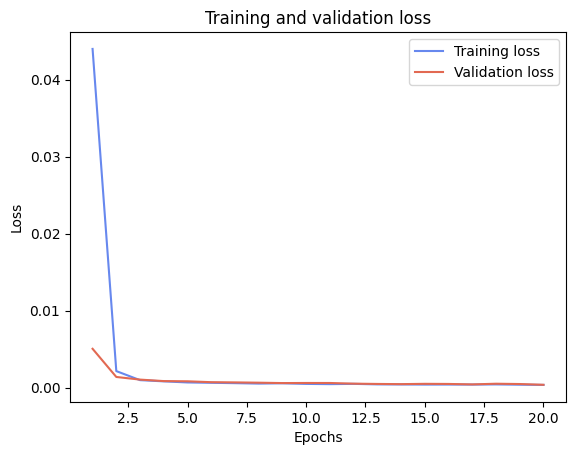

In [155]:
history_visualization(lstm_model_1_history, colors)

Выполним вывод различных метрик оценки качества модели.

In [156]:
print_metrics(lstm_model_1, X_test, y_test)

8/8 [==============================] - 0s 8ms/step
Mean squared error from neural network:  0.00034457702252961337
Mean absolute error from neural network:  0.013442551577169453
R2 score from neural network:  0.9950250763193006


Визуализируем предсказание модели и сравним с реальными данными.

8/8 [==============================] - 0s 8ms/step


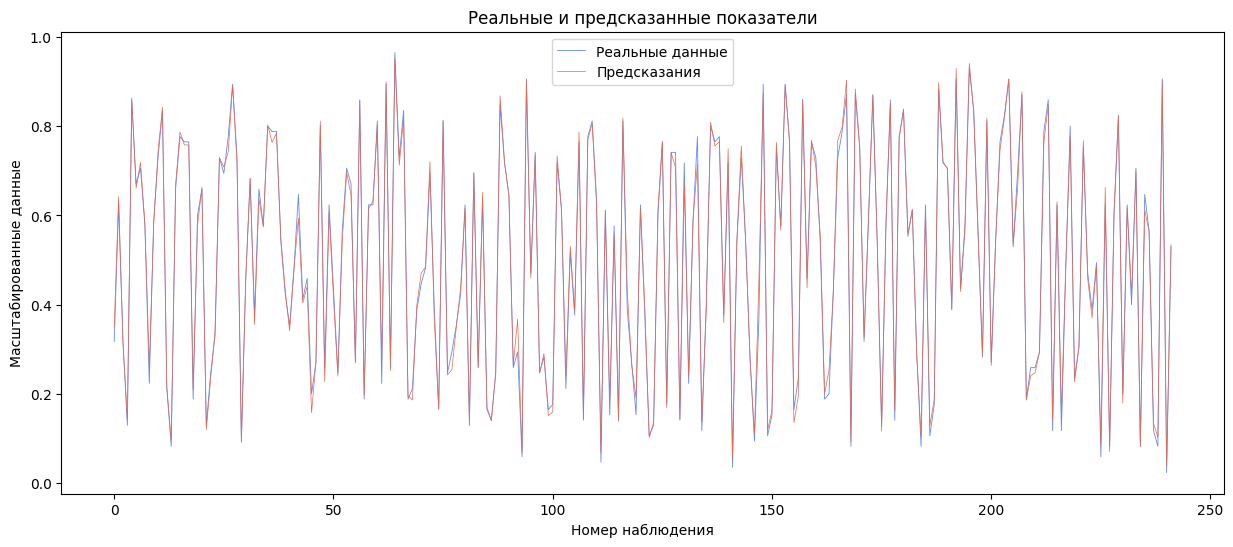

In [157]:
plot_predictions(lstm_model_1, X_test, y_test, colors)

Модель также хорошо справилась с задачей. Обучение шло гладко, на графике предсказанные значения практически совпадают с реальными.

####Модель №2

Увеличим количество эпох до 30 и будем уменьшать коэффициент обучения каждую эпоху, начиная с пятой. Добавим также раннюю остановку.

In [158]:
Params = dict()

lstm_params = dict()
dense_params = dict()
compile_params = dict()
train_params = dict()

lstm_params['units'] = 32
lstm_params['input_shape'] = (series_size,features_num)
lstm_params['activation'] = ['relu']
lstm_params['is_sequences'] = [False]

dense_params['units'] = 1
dense_params['activation'] = ['linear']

compile_params['loss'] = 'mean_squared_error'
compile_params['optimizer'] = 'adam'
compile_params['metrics'] = [
              'mean_absolute_error',
              'mean_squared_error',
              RSquare()
            ]

train_params['epochs'] = 30
train_params['batch_size'] = 32



Params['lstm_params'] = lstm_params
Params['dense_params'] = dense_params
Params['compile_params'] = compile_params
Params['train_params'] = train_params

In [159]:
Params

{'lstm_params': {'units': 32,
  'input_shape': (72, 4),
  'activation': ['relu'],
  'is_sequences': [False]},
 'dense_params': {'units': 1, 'activation': ['linear']},
 'compile_params': {'loss': 'mean_squared_error',
  'optimizer': 'adam',
  'metrics': ['mean_absolute_error',
   'mean_squared_error',
   <tensorflow_addons.metrics.r_square.RSquare at 0x7990fd282b00>]},
 'train_params': {'epochs': 30, 'batch_size': 32}}

In [160]:
lstm_model_2 = Sequential()

lstm_model_2.add(
    LSTM(
          Params['lstm_params']['units'],
          input_shape = Params['lstm_params']['input_shape'],
          activation = Params['lstm_params']['activation'][0],
          return_sequences = Params['lstm_params']['is_sequences'][0]
        )
      )

lstm_model_2.add(
    Dense(
        units = Params['dense_params']['units'],
        activation = Params['dense_params']['activation'][0]
      )
    )

lstm_model_2.compile(
    loss = Params['compile_params']['loss'],
    optimizer = Params['compile_params']['optimizer'],
    metrics = Params['compile_params']['metrics']
  )

lstm_model_2.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 32)                4736      
                                                                 
 dense_15 (Dense)            (None, 1)                 33        
                                                                 
Total params: 4769 (18.63 KB)
Trainable params: 4769 (18.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#####Обучение модели

In [161]:
early_stop = EarlyStopping(
    monitor = 'val_mae',
    patience = 7,
    mode = 'min',
    verbose = 1
  )

def scheduler(epoch, lr):
  if epoch < 5:
    return lr
  else:
    return lr * tf.math.exp(-0.05)

lr_cb = tf.keras.callbacks.LearningRateScheduler(scheduler)

callbacks_list = [
    early_stop,
    lr_cb
  ]

In [162]:
lstm_model_2_history = lstm_model_2.fit(
    X_train,
    y_train,
    validation_data = (X_val,y_val),
    epochs = Params['train_params']['epochs'],
    batch_size = Params['train_params']['batch_size'],
    verbose = 1
  )

Epoch 1/30
36/36 [==============================] - 3s 38ms/step - loss: 0.1491 - mean_absolute_error: 0.3177 - mean_squared_error: 0.1491 - r_square: -1.2871 - val_loss: 0.0486 - val_mean_absolute_error: 0.1934 - val_mean_squared_error: 0.0486 - val_r_square: 0.3076
Epoch 2/30
36/36 [==============================] - 1s 31ms/step - loss: 0.0123 - mean_absolute_error: 0.0840 - mean_squared_error: 0.0123 - r_square: 0.8112 - val_loss: 0.0033 - val_mean_absolute_error: 0.0472 - val_mean_squared_error: 0.0033 - val_r_square: 0.9536
Epoch 3/30
36/36 [==============================] - 1s 28ms/step - loss: 0.0023 - mean_absolute_error: 0.0382 - mean_squared_error: 0.0023 - r_square: 0.9650 - val_loss: 0.0023 - val_mean_absolute_error: 0.0392 - val_mean_squared_error: 0.0023 - val_r_square: 0.9672
Epoch 4/30
36/36 [==============================] - 1s 31ms/step - loss: 0.0018 - mean_absolute_error: 0.0338 - mean_squared_error: 0.0018 - r_square: 0.9723 - val_loss: 0.0017 - val_mean_absolute_e

#####Визуализация процесса обучения

После построим предсказания и визуализируем их. Построим график для визуализации
изменения оценки модели на разных эпохах.

<ipython-input-15-b0a0bfc8f622>:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "y" (-> color=(0.75, 0.75, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, loss, 'y', label='Training loss', color = colors[0])
<ipython-input-15-b0a0bfc8f622>:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_loss, 'r', label='Validation loss', color = colors[len(colors) - 1])


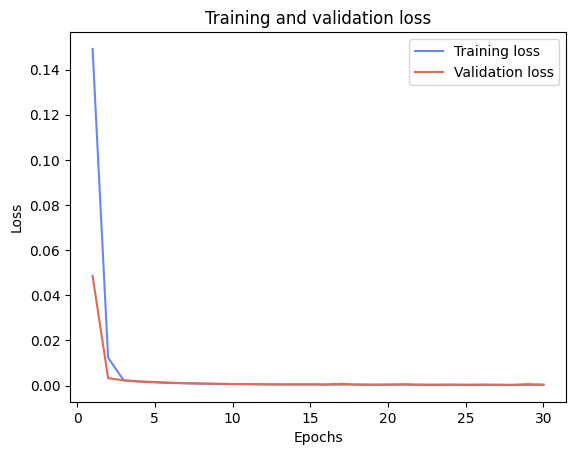

In [163]:
history_visualization(lstm_model_2_history, colors)

Выполним вывод различных метрик оценки качества модели.

In [164]:
print_metrics(lstm_model_2, X_test, y_test)

8/8 [==============================] - 0s 7ms/step
Mean squared error from neural network:  0.0003041774057471358
Mean absolute error from neural network:  0.012846200559315436
R2 score from neural network:  0.9956083566806748


Визуализируем предсказание модели и сравним с реальными данными.

8/8 [==============================] - 0s 8ms/step


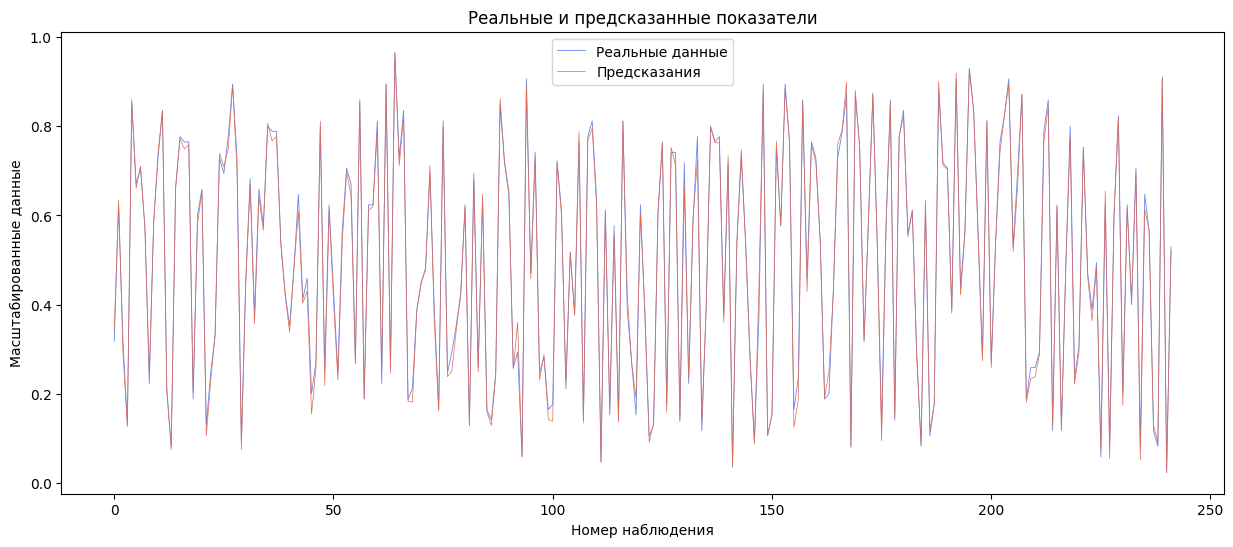

In [165]:
plot_predictions(lstm_model_2, X_test, y_test, colors)

Уменьшение коэффициента скорости обучения не улучшило, не и не ухудшило результаты.

####Модель №3

Оставим callback, уменьшающий скорость обучения на каждой эпохе, но увеличим количество нейронов до 128 в LSTM-слое и добавим dropout с веростностью 0.1. Увеличим количество эпох обучения до 100.

In [166]:
Params = dict()

lstm_params = dict()
dense_params = dict()
compile_params = dict()
train_params = dict()

lstm_params['units'] = 128
lstm_params['input_shape'] = (series_size,features_num)
lstm_params['activation'] = ['relu']
lstm_params['is_sequences'] = [False]
lstm_params['dropout'] = [0.1]

dense_params['units'] = 1
dense_params['activation'] = ['linear']

compile_params['loss'] = 'mean_squared_error'
compile_params['optimizer'] = 'adam'
compile_params['metrics'] = [
              'mean_absolute_error',
              'mean_squared_error',
              RSquare()
            ]

train_params['epochs'] = 100
train_params['batch_size'] = 32



Params['lstm_params'] = lstm_params
Params['dense_params'] = dense_params
Params['compile_params'] = compile_params
Params['train_params'] = train_params

In [167]:
Params

{'lstm_params': {'units': 128,
  'input_shape': (72, 4),
  'activation': ['relu'],
  'is_sequences': [False],
  'dropout': [0.1]},
 'dense_params': {'units': 1, 'activation': ['linear']},
 'compile_params': {'loss': 'mean_squared_error',
  'optimizer': 'adam',
  'metrics': ['mean_absolute_error',
   'mean_squared_error',
   <tensorflow_addons.metrics.r_square.RSquare at 0x7990f851bb20>]},
 'train_params': {'epochs': 100, 'batch_size': 32}}

In [168]:
lstm_model_3 = Sequential()

lstm_model_3.add(
    LSTM(
          Params['lstm_params']['units'],
          input_shape = Params['lstm_params']['input_shape'],
          activation = Params['lstm_params']['activation'][0],
          dropout = Params['lstm_params']['dropout'][0],
          return_sequences = Params['lstm_params']['is_sequences'][0]
        )
      )

lstm_model_3.add(
    Dense(
        units = Params['dense_params']['units'],
        activation = Params['dense_params']['activation'][0]
      )
    )

lstm_model_3.compile(
    loss = Params['compile_params']['loss'],
    optimizer = Params['compile_params']['optimizer'],
    metrics = Params['compile_params']['metrics']
  )

lstm_model_3.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 128)               68096     
                                                                 
 dense_16 (Dense)            (None, 1)                 129       
                                                                 
Total params: 68225 (266.50 KB)
Trainable params: 68225 (266.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#####Обучение модели

In [169]:
early_stop = EarlyStopping(
    monitor = 'val_mae',
    patience = 7,
    mode = 'min',
    verbose = 1
  )

def scheduler(epoch, lr):
  if epoch < 5:
    return lr
  else:
    return lr * tf.math.exp(-0.05)

lr_cb = tf.keras.callbacks.LearningRateScheduler(scheduler)

callbacks_list = [
    early_stop,
    lr_cb
  ]

In [170]:
lstm_model_3_history = lstm_model_3.fit(
    X_train,
    y_train,
    validation_data = (X_val,y_val),
    epochs = Params['train_params']['epochs'],
    batch_size = Params['train_params']['batch_size'],
    verbose = 1
  )

Epoch 1/100
36/36 [==============================] - 8s 163ms/step - loss: 0.0538 - mean_absolute_error: 0.1712 - mean_squared_error: 0.0538 - r_square: 0.1749 - val_loss: 0.0040 - val_mean_absolute_error: 0.0526 - val_mean_squared_error: 0.0040 - val_r_square: 0.9424
Epoch 2/100
36/36 [==============================] - 4s 98ms/step - loss: 0.0048 - mean_absolute_error: 0.0539 - mean_squared_error: 0.0048 - r_square: 0.9264 - val_loss: 0.0052 - val_mean_absolute_error: 0.0575 - val_mean_squared_error: 0.0052 - val_r_square: 0.9264
Epoch 3/100
36/36 [==============================] - 3s 81ms/step - loss: 0.0032 - mean_absolute_error: 0.0432 - mean_squared_error: 0.0032 - r_square: 0.9514 - val_loss: 0.0043 - val_mean_absolute_error: 0.0516 - val_mean_squared_error: 0.0043 - val_r_square: 0.9392
Epoch 4/100
36/36 [==============================] - 3s 84ms/step - loss: 0.0023 - mean_absolute_error: 0.0372 - mean_squared_error: 0.0023 - r_square: 0.9655 - val_loss: 0.0037 - val_mean_absolu

#####Визуализация процесса обучения

После построим предсказания и визуализируем их. Построим график для визуализации
изменения оценки модели на разных эпохах.

<ipython-input-15-b0a0bfc8f622>:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "y" (-> color=(0.75, 0.75, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, loss, 'y', label='Training loss', color = colors[0])
<ipython-input-15-b0a0bfc8f622>:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_loss, 'r', label='Validation loss', color = colors[len(colors) - 1])


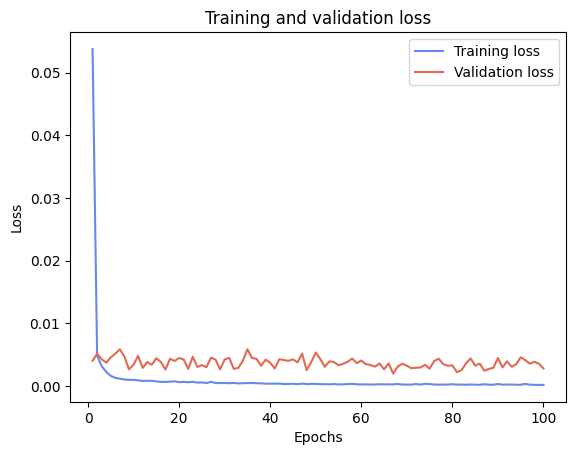

In [171]:
history_visualization(lstm_model_3_history, colors)

Выполним вывод различных метрик оценки качества модели.

In [172]:
print_metrics(lstm_model_3, X_test, y_test)

8/8 [==============================] - 1s 50ms/step
Mean squared error from neural network:  0.0028757865446410007
Mean absolute error from neural network:  0.04658540751853861
R2 score from neural network:  0.9584800562830862


Визуализируем предсказание модели и сравним с реальными данными.

8/8 [==============================] - 1s 59ms/step


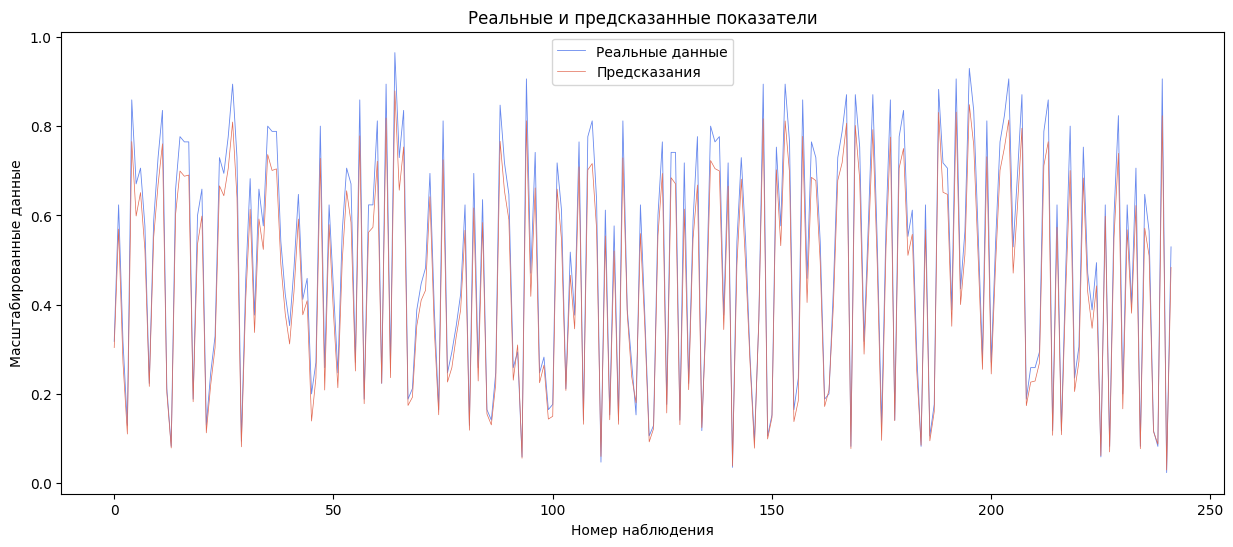

In [173]:
plot_predictions(lstm_model_3, X_test, y_test, colors)

Как видим, выбранные параметры архитектуры и обучения негативно сказались на качестве модели.

###Стек LSTM

Stacked LSTM (стековые LSTM) - это модель рекуррентной нейронной сети, которая состоит из нескольких LSTM-слоев, где каждый слой получает на вход выходной сигнал предыдущего слоя.

####Модель №1

Нейронная сеть содержит два LSTM-слоя. Первый слой содержит 64 нейрона, второй LSTM-слой содержит 32 нейрона, функции активации обоих слоев - relu. Размеры входного вектора (input_shape) - (количество наблюдений в серии, количество признаков).
Параметр return_sequences первого слоя установлен в True, то есть этот LSTM-слой будет получать на вход последовательности, и передавать последовательности на следующий слой. Во втором слое данный параметр установлен в False.

Слой Dense содержит 1 нейрон, функция активации - линейная.

В качестве функции потерь используем MSE, используемые метрики - MAE, MSE, R2. Оптимизатор - adam.

Модель будет обучена на 20 эпохах с размером батча, равным 32.





In [174]:
Params = dict()

lstm_params = dict()
dense_params = dict()
compile_params = dict()
train_params = dict()

lstm_params['units'] = [64, 32]
lstm_params['input_shape'] = (series_size,features_num)
lstm_params['activation'] = ['relu', 'relu']
lstm_params['is_sequences'] = [True, False]

dense_params['units'] = 1
dense_params['activation'] = ['linear']

compile_params['loss'] = 'mean_squared_error'
compile_params['optimizer'] = 'adam'
compile_params['metrics'] = [
              'mean_absolute_error',
              'mean_squared_error',
              RSquare()
            ]

train_params['epochs'] = 20
train_params['batch_size'] = 32



Params['lstm_params'] = lstm_params
Params['dense_params'] = dense_params
Params['compile_params'] = compile_params
Params['train_params'] = train_params

In [175]:
Params

{'lstm_params': {'units': [64, 32],
  'input_shape': (72, 4),
  'activation': ['relu', 'relu'],
  'is_sequences': [True, False]},
 'dense_params': {'units': 1, 'activation': ['linear']},
 'compile_params': {'loss': 'mean_squared_error',
  'optimizer': 'adam',
  'metrics': ['mean_absolute_error',
   'mean_squared_error',
   <tensorflow_addons.metrics.r_square.RSquare at 0x7990f88f1c30>]},
 'train_params': {'epochs': 20, 'batch_size': 32}}

In [176]:
stack_lstm_model_1 = Sequential()

stack_lstm_model_1.add(
    LSTM(
        Params['lstm_params']['units'][0],
        input_shape = Params['lstm_params']['input_shape'],
        activation = Params['lstm_params']['activation'][0],
        return_sequences = Params['lstm_params']['is_sequences'][0]
      )
    )


stack_lstm_model_1.add(
    LSTM(
        Params['lstm_params']['units'][1],
        activation = Params['lstm_params']['activation'][1],
        return_sequences = Params['lstm_params']['is_sequences'][1]
      )
    )

stack_lstm_model_1.add(
    Dense(
        units = Params['dense_params']['units'],
        activation = Params['dense_params']['activation'][0]
        )
    )

stack_lstm_model_1.compile(
    loss = Params['compile_params']['loss'],
    optimizer = Params['compile_params']['optimizer'],
    metrics = Params['compile_params']['metrics']
  )

stack_lstm_model_1.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 72, 64)            17664     
                                                                 
 lstm_13 (LSTM)              (None, 32)                12416     
                                                                 
 dense_17 (Dense)            (None, 1)                 33        
                                                                 
Total params: 30113 (117.63 KB)
Trainable params: 30113 (117.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#####Обучение модели

In [177]:
stack_lstm_model_1_history = stack_lstm_model_1.fit(
    X_train,
    y_train,
    validation_data = (X_val,y_val),
    epochs = Params['train_params']['epochs'],
    batch_size = Params['train_params']['batch_size'],
    verbose = 1
  )

Epoch 1/20
36/36 [==============================] - 6s 76ms/step - loss: 0.0857 - mean_absolute_error: 0.2173 - mean_squared_error: 0.0857 - r_square: -0.3142 - val_loss: 0.0073 - val_mean_absolute_error: 0.0697 - val_mean_squared_error: 0.0073 - val_r_square: 0.8954
Epoch 2/20
36/36 [==============================] - 2s 63ms/step - loss: 0.0039 - mean_absolute_error: 0.0491 - mean_squared_error: 0.0039 - r_square: 0.9405 - val_loss: 0.0032 - val_mean_absolute_error: 0.0464 - val_mean_squared_error: 0.0032 - val_r_square: 0.9547
Epoch 3/20
36/36 [==============================] - 2s 64ms/step - loss: 0.0023 - mean_absolute_error: 0.0382 - mean_squared_error: 0.0023 - r_square: 0.9649 - val_loss: 0.0029 - val_mean_absolute_error: 0.0427 - val_mean_squared_error: 0.0029 - val_r_square: 0.9581
Epoch 4/20
36/36 [==============================] - 3s 80ms/step - loss: 0.0021 - mean_absolute_error: 0.0352 - mean_squared_error: 0.0021 - r_square: 0.9684 - val_loss: 0.0021 - val_mean_absolute_e

#####Визуализация процесса обучения

После построим предсказания и визуализируем их. Построим график для визуализации
изменения оценки модели на разных эпохах.

<ipython-input-15-b0a0bfc8f622>:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "y" (-> color=(0.75, 0.75, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, loss, 'y', label='Training loss', color = colors[0])
<ipython-input-15-b0a0bfc8f622>:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_loss, 'r', label='Validation loss', color = colors[len(colors) - 1])


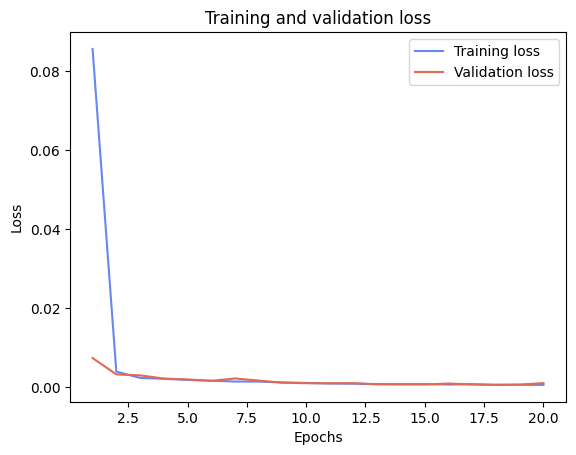

In [178]:
history_visualization(stack_lstm_model_1_history, colors)

Выполним вывод различных метрик оценки качества модели.

In [179]:
print_metrics(stack_lstm_model_1, X_test, y_test)

8/8 [==============================] - 1s 19ms/step
Mean squared error from neural network:  0.0008962833937398397
Mean absolute error from neural network:  0.024801992744345035
R2 score from neural network:  0.9870596668129524


Визуализируем предсказание модели и сравним с реальными данными.

8/8 [==============================] - 0s 19ms/step


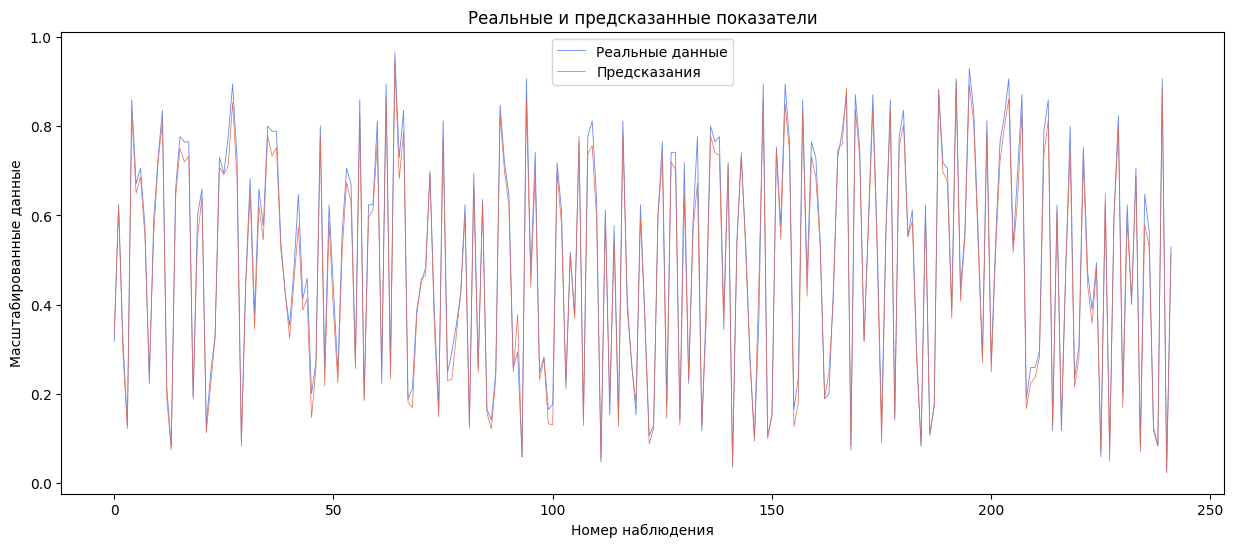

In [180]:
plot_predictions(stack_lstm_model_1, X_test, y_test, colors)

Как видим из графиков, обучение модели проходило гладко и модель обладает высоким качеством прогноза.

####Модель №2

Функцией активации в LSTM по умолчанию является гиперболический тангенс. Восстановим значения по умолчанию.

In [181]:
Params = dict()

lstm_params = dict()
dense_params = dict()
compile_params = dict()
train_params = dict()

lstm_params['units'] = [64, 32]
lstm_params['input_shape'] = (series_size,features_num)
lstm_params['activation'] = ['tanh', 'tanh']
lstm_params['is_sequences'] = [True, False]
lstm_params['dropout'] = [0.00, 0.00]

dense_params['units'] = 1
dense_params['activation'] = ['linear']

compile_params['loss'] = 'mean_squared_error'
compile_params['optimizer'] = 'adam'
compile_params['metrics'] = [
              'mean_absolute_error',
              'mean_squared_error',
              RSquare()
            ]

train_params['epochs'] = 20
train_params['batch_size'] = 32



Params['lstm_params'] = lstm_params
Params['dense_params'] = dense_params
Params['compile_params'] = compile_params
Params['train_params'] = train_params

In [182]:
Params

{'lstm_params': {'units': [64, 32],
  'input_shape': (72, 4),
  'activation': ['tanh', 'tanh'],
  'is_sequences': [True, False],
  'dropout': [0.0, 0.0]},
 'dense_params': {'units': 1, 'activation': ['linear']},
 'compile_params': {'loss': 'mean_squared_error',
  'optimizer': 'adam',
  'metrics': ['mean_absolute_error',
   'mean_squared_error',
   <tensorflow_addons.metrics.r_square.RSquare at 0x7991103ddcf0>]},
 'train_params': {'epochs': 20, 'batch_size': 32}}

In [183]:
stack_lstm_model_2 = Sequential()

stack_lstm_model_2.add(
    LSTM(
        Params['lstm_params']['units'][0],
        input_shape = Params['lstm_params']['input_shape'],
        activation = Params['lstm_params']['activation'][0],
        dropout = Params['lstm_params']['dropout'][0],
        return_sequences = Params['lstm_params']['is_sequences'][0]
      )
    )


stack_lstm_model_2.add(
    LSTM(
        Params['lstm_params']['units'][1],
        activation = Params['lstm_params']['activation'][1],
        dropout = Params['lstm_params']['dropout'][1],
        return_sequences = Params['lstm_params']['is_sequences'][1]
      )
    )

stack_lstm_model_2.add(
    Dense(
        units = Params['dense_params']['units'],
        activation = Params['dense_params']['activation'][0]
        )
    )

stack_lstm_model_2.compile(
    loss = Params['compile_params']['loss'],
    optimizer = Params['compile_params']['optimizer'],
    metrics = Params['compile_params']['metrics']
  )

stack_lstm_model_2.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 72, 64)            17664     
                                                                 
 lstm_15 (LSTM)              (None, 32)                12416     
                                                                 
 dense_18 (Dense)            (None, 1)                 33        
                                                                 
Total params: 30113 (117.63 KB)
Trainable params: 30113 (117.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#####Обучение модели

In [184]:
stack_lstm_model_2_history = stack_lstm_model_2.fit(
    X_train,
    y_train,
    validation_data = (X_val,y_val),
    epochs = Params['train_params']['epochs'],
    batch_size = Params['train_params']['batch_size'],
    verbose = 1
  )

Epoch 1/20
36/36 [==============================] - 10s 156ms/step - loss: 0.0295 - mean_absolute_error: 0.1154 - mean_squared_error: 0.0295 - r_square: 0.5480 - val_loss: 0.0043 - val_mean_absolute_error: 0.0518 - val_mean_squared_error: 0.0043 - val_r_square: 0.9391
Epoch 2/20
36/36 [==============================] - 2s 69ms/step - loss: 0.0025 - mean_absolute_error: 0.0388 - mean_squared_error: 0.0025 - r_square: 0.9624 - val_loss: 0.0019 - val_mean_absolute_error: 0.0343 - val_mean_squared_error: 0.0019 - val_r_square: 0.9730
Epoch 3/20
36/36 [==============================] - 2s 65ms/step - loss: 0.0018 - mean_absolute_error: 0.0332 - mean_squared_error: 0.0018 - r_square: 0.9720 - val_loss: 0.0015 - val_mean_absolute_error: 0.0302 - val_mean_squared_error: 0.0015 - val_r_square: 0.9782
Epoch 4/20
36/36 [==============================] - 2s 66ms/step - loss: 0.0015 - mean_absolute_error: 0.0296 - mean_squared_error: 0.0015 - r_square: 0.9773 - val_loss: 0.0013 - val_mean_absolute_

#####Визуализация процесса обучения

После построим предсказания и визуализируем их. Построим график для визуализации
изменения оценки модели на разных эпохах.

<ipython-input-15-b0a0bfc8f622>:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "y" (-> color=(0.75, 0.75, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, loss, 'y', label='Training loss', color = colors[0])
<ipython-input-15-b0a0bfc8f622>:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_loss, 'r', label='Validation loss', color = colors[len(colors) - 1])


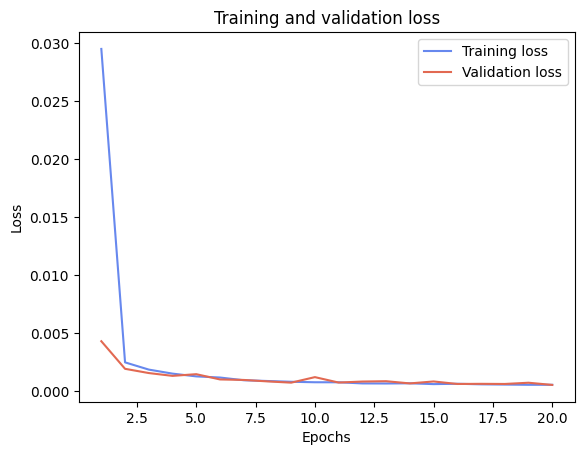

In [185]:
history_visualization(stack_lstm_model_2_history, colors)

Выполним вывод различных метрик оценки качества модели.

In [186]:
print_metrics(stack_lstm_model_2, X_test, y_test)

8/8 [==============================] - 1s 18ms/step
Mean squared error from neural network:  0.0005249290154705398
Mean absolute error from neural network:  0.016431956893801114
R2 score from neural network:  0.99242119578787


Визуализируем предсказание модели и сравним с реальными данными.

8/8 [==============================] - 0s 20ms/step


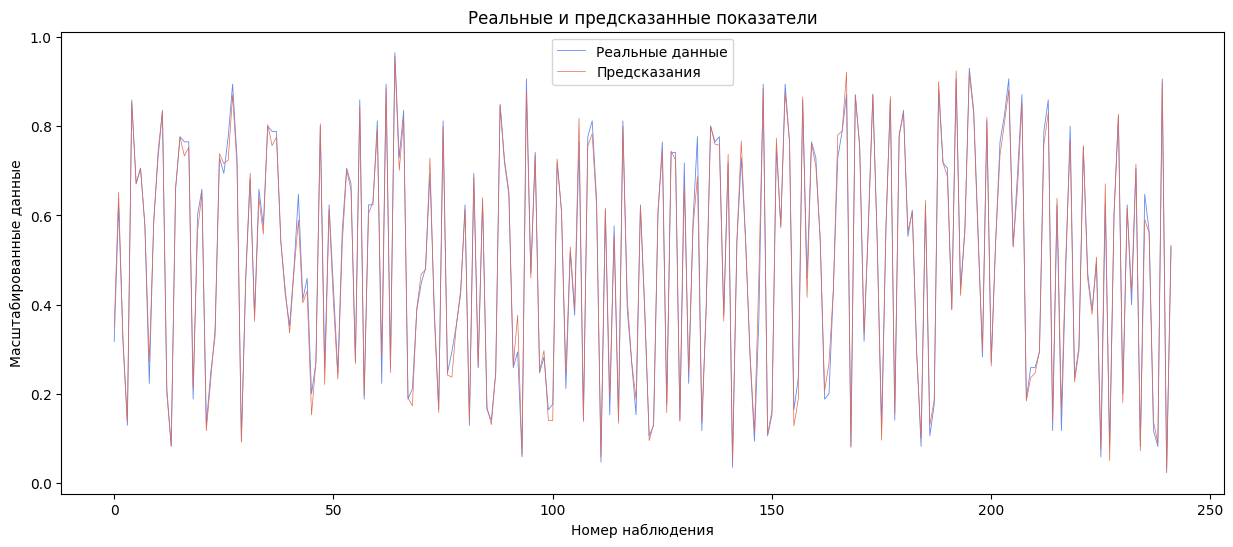

In [187]:
plot_predictions(stack_lstm_model_2, X_test, y_test, colors)

Модель также обладает высокими характеристиками точности прогноза.

####Модель №3

Снова возьмем в качестве функции активации внутренних LSTM-слоёв relu. Добавим dropout. Установим соответствующий параметр в LSTM-слоях в 0.01 и 0.03.

In [188]:
Params = dict()

lstm_params = dict()
dense_params = dict()
compile_params = dict()
train_params = dict()

lstm_params['units'] = [64, 32]
lstm_params['input_shape'] = (series_size,features_num)
lstm_params['activation'] = ['relu', 'relu']
lstm_params['is_sequences'] = [True, False]
lstm_params['dropout'] = [0.01, 0.03]

dense_params['units'] = 1
dense_params['activation'] = ['linear']

compile_params['loss'] = 'mean_squared_error'
compile_params['optimizer'] = 'adam'
compile_params['metrics'] = [
              'mean_absolute_error',
              'mean_squared_error',
              RSquare()
            ]

train_params['epochs'] = 20
train_params['batch_size'] = 32



Params['lstm_params'] = lstm_params
Params['dense_params'] = dense_params
Params['compile_params'] = compile_params
Params['train_params'] = train_params

In [189]:
Params

{'lstm_params': {'units': [64, 32],
  'input_shape': (72, 4),
  'activation': ['relu', 'relu'],
  'is_sequences': [True, False],
  'dropout': [0.01, 0.03]},
 'dense_params': {'units': 1, 'activation': ['linear']},
 'compile_params': {'loss': 'mean_squared_error',
  'optimizer': 'adam',
  'metrics': ['mean_absolute_error',
   'mean_squared_error',
   <tensorflow_addons.metrics.r_square.RSquare at 0x799113e47ee0>]},
 'train_params': {'epochs': 20, 'batch_size': 32}}

In [190]:
stack_lstm_model_3 = Sequential()

stack_lstm_model_3.add(
    LSTM(
        Params['lstm_params']['units'][0],
        input_shape = Params['lstm_params']['input_shape'],
        activation = Params['lstm_params']['activation'][0],
        dropout = Params['lstm_params']['dropout'][0],
        return_sequences = Params['lstm_params']['is_sequences'][0]
      )
    )


stack_lstm_model_3.add(
    LSTM(
        Params['lstm_params']['units'][1],
        activation = Params['lstm_params']['activation'][1],
        dropout = Params['lstm_params']['dropout'][1],
        return_sequences = Params['lstm_params']['is_sequences'][1]
      )
    )

stack_lstm_model_3.add(
    Dense(
        units = Params['dense_params']['units'],
        activation = Params['dense_params']['activation'][0]
        )
    )

stack_lstm_model_3.compile(
    loss = Params['compile_params']['loss'],
    optimizer = Params['compile_params']['optimizer'],
    metrics = Params['compile_params']['metrics']
  )

stack_lstm_model_3.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 72, 64)            17664     
                                                                 
 lstm_17 (LSTM)              (None, 32)                12416     
                                                                 
 dense_19 (Dense)            (None, 1)                 33        
                                                                 
Total params: 30113 (117.63 KB)
Trainable params: 30113 (117.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#####Обучение модели

In [191]:
stack_lstm_model_3_history = stack_lstm_model_3.fit(
    X_train,
    y_train,
    validation_data = (X_val,y_val),
    epochs = Params['train_params']['epochs'],
    batch_size = Params['train_params']['batch_size'],
    verbose = 1
  )

Epoch 1/20
36/36 [==============================] - 7s 106ms/step - loss: 0.0977 - mean_absolute_error: 0.2377 - mean_squared_error: 0.0977 - r_square: -0.4980 - val_loss: 0.0101 - val_mean_absolute_error: 0.0833 - val_mean_squared_error: 0.0101 - val_r_square: 0.8557
Epoch 2/20
36/36 [==============================] - 4s 116ms/step - loss: 0.0064 - mean_absolute_error: 0.0625 - mean_squared_error: 0.0064 - r_square: 0.9014 - val_loss: 0.0034 - val_mean_absolute_error: 0.0483 - val_mean_squared_error: 0.0034 - val_r_square: 0.9521
Epoch 3/20
36/36 [==============================] - 3s 74ms/step - loss: 0.0032 - mean_absolute_error: 0.0449 - mean_squared_error: 0.0032 - r_square: 0.9507 - val_loss: 0.0027 - val_mean_absolute_error: 0.0429 - val_mean_squared_error: 0.0027 - val_r_square: 0.9614
Epoch 4/20
36/36 [==============================] - 2s 68ms/step - loss: 0.0027 - mean_absolute_error: 0.0408 - mean_squared_error: 0.0027 - r_square: 0.9590 - val_loss: 0.0025 - val_mean_absolute

#####Визуализация процесса обучения

После построим предсказания и визуализируем их. Построим график для визуализации
изменения оценки модели на разных эпохах.

<ipython-input-15-b0a0bfc8f622>:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "y" (-> color=(0.75, 0.75, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, loss, 'y', label='Training loss', color = colors[0])
<ipython-input-15-b0a0bfc8f622>:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_loss, 'r', label='Validation loss', color = colors[len(colors) - 1])


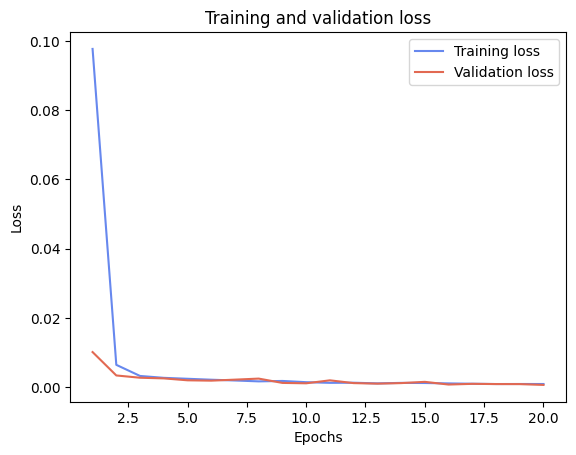

In [192]:
history_visualization(stack_lstm_model_3_history, colors)

Выполним вывод различных метрик оценки качества модели.

In [193]:
print_metrics(stack_lstm_model_3, X_test, y_test)

8/8 [==============================] - 0s 16ms/step
Mean squared error from neural network:  0.0006805275437146154
Mean absolute error from neural network:  0.01844590904121412
R2 score from neural network:  0.9901747000779685


Визуализируем предсказание модели и сравним с реальными данными.

8/8 [==============================] - 0s 16ms/step


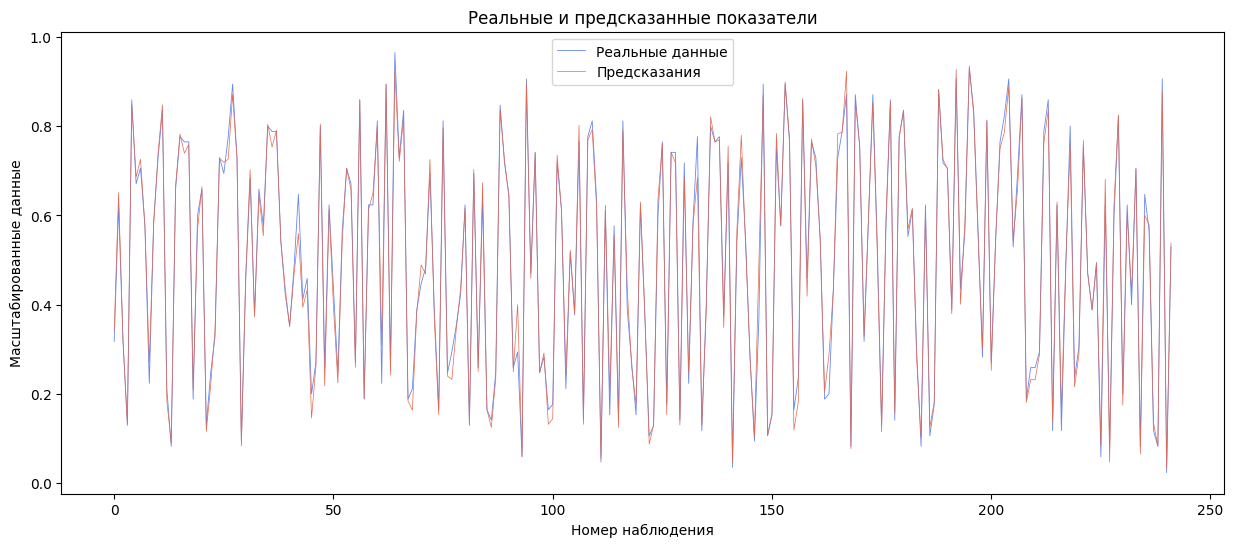

In [194]:
plot_predictions(stack_lstm_model_3, X_test, y_test, colors)

Модель также обладает высокими характеристиками точности прогноза.

##Выводы

Построим график, отображающий значение коэффициента детерминации для каждой модели.

In [195]:
if 'scores_df' in globals():
  scores_df = scores_df[0:0]

scores_df = pd.DataFrame(columns=['architecture', 'model_number', 'R2'])

print(scores_df)

Empty DataFrame
Columns: [architecture, model_number, R2]
Index: []


In [196]:
scores_df.loc[ len(scores_df.index )] = ['SimpleRNN', 1, float("{0:.4f}".format(r2_score(y_test, rnn_model_1.predict(X_test))))]
scores_df.loc[ len(scores_df.index )] = ['SimpleRNN', 2, float("{0:.4f}".format(r2_score(y_test, rnn_model_2.predict(X_test))))]
scores_df.loc[ len(scores_df.index )] = ['SimpleRNN', 3, float("{0:.4f}".format(r2_score(y_test, rnn_model_3.predict(X_test))))]
scores_df.loc[ len(scores_df.index )] = ['SimpleRNN', 4, float("{0:.4f}".format(r2_score(y_test, rnn_model_4.predict(X_test))))]

scores_df.loc[ len(scores_df.index )] = ['LSTM', 1, float("{0:.4f}".format(r2_score(y_test, lstm_model_1.predict(X_test))))]
scores_df.loc[ len(scores_df.index )] = ['LSTM', 2, float("{0:.4f}".format(r2_score(y_test, lstm_model_2.predict(X_test))))]
scores_df.loc[ len(scores_df.index )] = ['LSTM', 3, float("{0:.4f}".format(r2_score(y_test, lstm_model_3.predict(X_test))))]

scores_df.loc[ len(scores_df.index )] = ['StackedLSTM', 1, float("{0:.4f}".format(r2_score(y_test, stack_lstm_model_1.predict(X_test))))]
scores_df.loc[ len(scores_df.index )] = ['StackedLSTM', 2, float("{0:.4f}".format(r2_score(y_test, stack_lstm_model_2.predict(X_test))))]
scores_df.loc[ len(scores_df.index )] = ['StackedLSTM', 3, float("{0:.4f}".format(r2_score(y_test, stack_lstm_model_3.predict(X_test))))]

print(scores_df)

8/8 [==============================] - 0s 24ms/step
  architecture  model_number      R2
0    SimpleRNN             1  0.9973
1    SimpleRNN             2  0.9958
2    SimpleRNN             3  0.9973
3    SimpleRNN             4  0.9430
4         LSTM             1  0.9950
5         LSTM             2  0.9956
6         LSTM             3  0.9585
7  StackedLSTM             1  0.9871
8  StackedLSTM             2  0.9924
9  StackedLSTM             3  0.9902


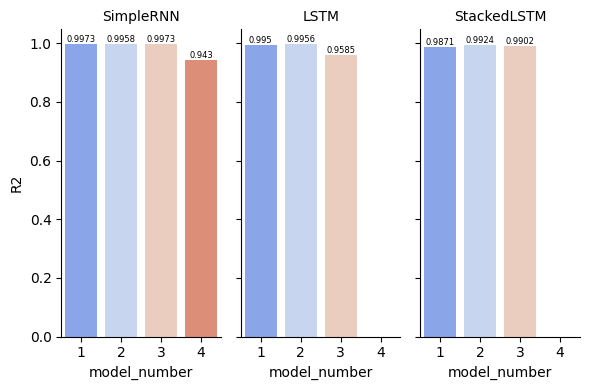

In [197]:
g = sns.catplot(
    scores_df,
    kind="bar",
    x="model_number",
    y="R2",
    col="architecture",
    height=4,
    aspect=.5,
    palette = palette
  )

for i in range(0, 3):
    g.axes[0,i].bar_label(
      g.axes[0,i].containers[0],
      size=6
    )

g.set_titles("{col_name}")

Как видим, все модели достаточно хорошо предсказывают значение температуры в Якутске, однако следует с осторожностью применять dropout, так как он может привести к снижению качества прогноза.